<a href="https://colab.research.google.com/github/skughered/notion/blob/main/wfi_taa_python_v1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**WFI TAA Python**

# **Library Import, API Settings & Data Download**

 Only open to change API Key

###**Import Libraries**

First block imports different python libraries that are required via the 'pip install' method.

In [ ]:
!pip install tiingo
!pip install quantstats
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 863.8 kB/s eta 0:00:00


Import different libraries & define them

In [ ]:
import pandas as pd
from tiingo import TiingoClient as tii
from datetime import datetime as dt
import numpy as np
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter, FixedLocator
import seaborn as sns

### **Importing & preparing data from Tiingo's API**


- The user then needs to add their own Tiingo API token which can be obtained here https://www.tiingo.com/
- The user then needs to define a list of instruments to obtain data for, this has already been done for the strategies used.
- Given the first data for the "cash" asset BIL is 01/07/2007 we only request data from this date onwards.
- The code then pulls data to the 'end_date' which is today.
- We then request data for the 'intrument_list' for the requency required 'daily' & the type of data 'adjClose'.
- We then run the code to obtain the dataframe (table) of adjusted closing prices & then calculate the percentage change, creating a new dataframe for this data.
- To finish we then print out the top 5 rows of data along with column headings.
- Assuming this runs correctly, there will be no errors & these two dataframe previews will show.

In [ ]:
### API code ###
def tiingo_data(metric_name='adjClose'):
  # Your Tinngo.com API Token
  api = '9c6d1991a2f70ee6e29f20df344feb9e1d90267d'

  # Configuration
  config = { 'api_key': api, 'session': True}
  client = tii(config)

  # Instrument List
  instrument_list = ['BIL', 'SHY', 'IEF', 'TLT', 'SPY', 'QQQ', 'VEA', 'EFA',
                    'VWO', 'DBC', 'VNQ', 'HYG', 'TIP', 'AGG', 'LQD', 'VTI', 'IWM',
                     'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLU', 'XLY',
                     'EEM', 'EWJ', 'GLD']

  # Fetching adjusted close prices since 31/07/2007
  start_date = '2007-06-30'
  # Dynamic end date (today's date)
  end_date = dt.now().strftime('%Y-%m-%d')


  # Get a DataFrame of adjusted close prices for the list of symbols
  ticker_history = client.get_dataframe(instrument_list,
                                      frequency='daily',
                                      metric_name='adjClose',
                                      startDate=start_date,
                                      endDate=end_date)

  ticker_history.index = pd.to_datetime(ticker_history.index)

  return ticker_history

# Using the function above create a price dataframe & also a daily percentage change dataframe
load_etf_prices = tiingo_data(metric_name='adjClose')
etf_pct_returns = load_etf_prices.pct_change()
etf_last_price = tiingo_data(metric_name='Close')

# Print samples of the data loaded to check it looks correct & has loaded.
# print(load_etf_prices.round(3).head().to_string())
# print(load_etf_prices.round(3).tail().to_string())
# print(etf_pct_returns.round(3).head().to_string())
# print(etf_pct_returns.round(3).tail().to_string())
# print(etf_last_price.round(3).head().to_string())
# print(etf_last_price.round(3).tail().to_string())

#TODO: Add data caching to reduce API calls once dataset grows.

####First Data Record Test

In [ ]:
# Find the first non-NaN value for each ETF
inception_dates = load_etf_prices.apply(pd.Series.first_valid_index)
inception_dates

BIL   2007-07-02 00:00:00+00:00
SHY   2007-07-02 00:00:00+00:00
IEF   2007-07-02 00:00:00+00:00
TLT   2007-07-02 00:00:00+00:00
SPY   2007-07-02 00:00:00+00:00
QQQ   2007-07-02 00:00:00+00:00
VEA   2007-07-26 00:00:00+00:00
EFA   2007-07-02 00:00:00+00:00
VWO   2007-07-02 00:00:00+00:00
DBC   2007-07-02 00:00:00+00:00
VNQ   2007-07-02 00:00:00+00:00
HYG   2007-07-02 00:00:00+00:00
TIP   2007-07-02 00:00:00+00:00
AGG   2007-07-02 00:00:00+00:00
LQD   2007-07-02 00:00:00+00:00
VTI   2007-07-02 00:00:00+00:00
IWM   2007-07-02 00:00:00+00:00
XLP   2007-07-02 00:00:00+00:00
XLE   2007-07-02 00:00:00+00:00
XLF   2007-07-02 00:00:00+00:00
XLV   2007-07-02 00:00:00+00:00
XLI   2007-07-02 00:00:00+00:00
XLK   2007-07-02 00:00:00+00:00
XLB   2007-07-02 00:00:00+00:00
XLU   2007-07-02 00:00:00+00:00
XLY   2007-07-02 00:00:00+00:00
EEM   2007-07-02 00:00:00+00:00
EWJ   2007-07-02 00:00:00+00:00
GLD   2007-07-02 00:00:00+00:00
dtype: datetime64[ns, UTC]

# **Functions**

This section contains many different functions which are used within the notebook.

## Plotting Functions

### Cumulative Return Plot

In [ ]:
def create_cumula_rtn_drawdown_chart_function(rtn, dd):
    # Find Start & End date from input df 'rtn'
    # Get the first and last date in the index
    chart_start = rtn.index.min()
    chart_end = rtn.index.max()

    # Format the dates as "Jan - 2005"
    chart_start_formatted = chart_start.strftime("%b - %Y")
    chart_end_formatted = chart_end.strftime("%b - %Y")

    # Create a Matplotlib figure with a custom layout (two rows, two columns)
    fig = plt.figure(figsize=(12, 8))
    gs = fig.add_gridspec(2, 2, width_ratios=[3, 1], height_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    # Chart 1: Cumulative Returns for Portfolio 1 (Upper Left)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(rtn['Portfolio'], label='Portfolio', color='blue', alpha=0.75)
    ax1.plot(rtn['Benchmark'], label='Benchmark', color='green', alpha=0.75)
    ax1.set_ylabel('Cumulative Returns')
    ax1.set_yscale('log')
    ax1.grid(True)
    ax1.legend(loc='upper left')

    # Chart 2: Drawdown for Portfolio 1 (Lower Left)
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
    ax2.plot(dd['Portfolio'].index, dd['Portfolio'], label='Portfolio', color='blue', alpha=0.75)
    ax2.plot(dd['Benchmark'].index, dd['Benchmark'], label='Benchmark', color='green', alpha=0.75)
    ax2.set_ylabel('Drawdown (%)')
    ax2.grid(True)
    # ax2.legend(loc='upper left')

    # Create a histogram on the right for the drawdown data (Lower Right)
    ax3 = fig.add_subplot(gs[1, 1])
    histrange = (np.min([dd['Portfolio'].min(), dd['Benchmark'].min()]),
                np.max([dd['Portfolio'].max(), dd['Benchmark'].max()]))
    ax3.hist(dd['Portfolio'], bins=25, color='blue', alpha=0.5, orientation='horizontal', range=histrange)
    ax3.hist(dd['Benchmark'], bins=25, color='green', alpha=0.5, orientation='horizontal', range=histrange)
    ax3.set_xlabel('Frequency')
    ax3.grid(True)

    # Add a title to the plot
    plt.suptitle('Cumulative Return & Drawdown - Portfolio & Benchmark', fontsize=16)

    # Add source information centered on the left-hand main plot
    source_info = f"Data sourced by Tiingo - (Start Date: {chart_start_formatted} End Date: {chart_end_formatted})"
    ax1.text(0.5, -0.15, source_info, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0.1)  # Adjust subplot layout for title and reduce vertical space





### Rolling Volatility Plot

In [ ]:
def create_rolling_volatility_chart_function(rtn):
    # Find Start & End date from input df 'rtn'
    # Get the first and last date in the index
    chart_start = rtn.index.min()
    chart_end = rtn.index.max()

    # Format the dates as "Jan - 2005"
    chart_start_formatted = chart_start.strftime("%b - %Y")
    chart_end_formatted = chart_end.strftime("%b - %Y")

    # Calculate rolling volatility & then plot spread
    vol_3m = (rtn.rolling(window=63, min_periods=21).std()) * np.sqrt(252) * 100
    vol_diff = (vol_3m['Portfolio'] - vol_3m['Benchmark'])

    # Calculate full sample averages for all three plots
    portfolio_avg = vol_3m['Portfolio'].mean()
    benchmark_avg = vol_3m['Benchmark'].mean()
    spread_avg = vol_diff.mean()

    # Create a Matplotlib figure with two subplots (charts) and histograms
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8), gridspec_kw={'width_ratios': [6, 1], 'height_ratios': [2, 1]})

    fig.subplots_adjust(wspace=0.00)

    # Chart 1: Volatility for Portfolio
    ax1.plot(vol_3m['Portfolio'], label='Portfolio', color='blue', alpha=0.75)
    ax1.axhline(y=portfolio_avg, color='blue', linestyle='--', label=f'Portfolio Avg ({portfolio_avg:.2f}%)')
    ax1.set_ylabel('Volatility')
    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax1.tick_params(axis='x', labelbottom=False)  # Hide X-axis labels
    ax1.xaxis.set_visible(False)  # Hide X-axis

    # Chart 2: Volatility for Benchmark
    ax1.plot(vol_3m['Benchmark'], label='Benchmark', color='green', alpha=0.75)
    ax1.axhline(y=benchmark_avg, color='green', linestyle='--', label=f'Benchmark Avg ({benchmark_avg:.2f}%)')
    ax1.legend(loc='upper center')

    # Chart 3: Volatility Spread
    ax3.plot(vol_diff.index, vol_diff,color='firebrick', alpha=0.75)
    ax3.axhline(y=spread_avg, color='firebrick', linestyle='--', label=f'Spread Avg ({spread_avg:.2f}%)')
    ax3.set_ylabel('Volatility Spread (%)')
    ax3.grid(True)

    # Add histograms on the right for Chart 1 and Chart 2
    histrange = (np.min([vol_3m['Portfolio'].min(), vol_3m['Benchmark'].min()]),
                np.max([vol_3m['Portfolio'].max(), vol_3m['Benchmark'].max()]))
    ax2.hist(vol_3m['Portfolio'], bins=25, color='blue', alpha=0.5, orientation='horizontal', range=histrange)
    ax2.hist(vol_3m['Benchmark'], bins=25, color='green', alpha=0.5, orientation='horizontal', range=histrange)
    ax2.grid(True)
    ax2.tick_params(axis='y', labelleft=False)  # Hide Y-axis labels
    ax2.yaxis.set_visible(False)  # Hide Y-axis

    # Modify ax2 to remove X-axis labels for the upper histogram
    # ax2.set_xticklabels([])  # Remove X-axis labels
    # ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)  # Hide X-axis ticks

    # Add histogram on the right for Chart 3
    ax4.hist(vol_diff, bins=15, color='firebrick', alpha=0.5, orientation='horizontal')
    ax4.set_xlabel('Frequency')
    ax4.grid(True)
    ax4.tick_params(axis='y', labelleft=False)  # Hide Y-axis labels
    ax4.yaxis.set_visible(False)  # Hide Y-axis

    # Add a title to the plot with a smaller 'y' value
    plt.suptitle('Rolling 3 Month Volatility & Spread - Portfolio & Benchmark', fontsize=16, y=0.92)  # Adjust the 'y' parameter

    # Add source information centered on the left-hand main plot
    source_info = f"Data sourced by Tiingo - (Start Date: {chart_start_formatted} End Date: {chart_end_formatted})"
    ax3.text(0.5, -0.65, source_info, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)

    plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=0.1)  # Adjust subplot layout for title and reduce vertical

### Monthly Return Heatmap

In [ ]:
def plot_monthly_returns_heatmap(portfolio_returns):
    # Aggregate daily returns into monthly returns
    monthly_returns = portfolio_returns.resample('M').sum()

    # Ensure the index is a DatetimeIndex
    monthly_returns.index = pd.to_datetime(monthly_returns.index)

    # Get the full range of months and years
    full_range = pd.date_range(start=monthly_returns.index.min(), end=monthly_returns.index.max(), freq='M')

    # Create a DataFrame with the full range of months and years
    full_df = pd.DataFrame(index=full_range)

    # Merge with the original data to fill in missing values with NaN
    merged_returns_df = full_df.merge(monthly_returns.to_frame(), left_index=True, right_index=True, how='left')

    # Convert monthly_returns to a DataFrame
    monthly_returns_df = merged_returns_df['Portfolio'].to_frame()

    # Extract month names and year
    monthly_returns_df['Month'] = monthly_returns_df.index.strftime('%b')
    monthly_returns_df['Year'] = monthly_returns_df.index.year

    # Set the order of months
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_returns_df['Month'] = pd.Categorical(monthly_returns_df['Month'], categories=month_order, ordered=True)

    # Set the order of years (latest year at the top)
    year_order = monthly_returns_df['Year'].sort_values(ascending=False).unique()

    # Create a pivot table with NaN for missing months
    pivot_table = monthly_returns_df.pivot_table(index='Year', columns='Month', values='Portfolio', aggfunc='sum')

    # Reindex the pivot table to ensure the order of years
    pivot_table = pivot_table.reindex(year_order)

    # Convert data to percentages
    pivot_table *= 100

    # Replace 0.00s with NaN
    pivot_table.replace(0, np.nan, inplace=True)

    # Plotting
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(pivot_table, cmap='RdYlGn', center=0, linewidths=0.5, annot=True, fmt=".2f", cbar_kws={'label': 'Returns (%)'}, square=True, cbar=False)
    plt.title('Monthly Returns Heatmap')
    plt.ylabel('Year')
    plt.xlabel('Month')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('auto')
    plt.tight_layout()
    plt.show()

### Pie Chart Plotting Function

In [ ]:
def plot_pie_chart(output_pie_weight):
    output_pie_weight = output_pie_weight[output_pie_weight > 0].dropna(how='all')

    # Generate a color palette with distinct colors
    num_assets = len(output_pie_weight)
    color_palette = sns.color_palette("husl", n_colors=num_assets)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    def create_pie(ax, data, title):
        labels = data.dropna().index
        values = data.dropna()
        colors = color_palette[:len(labels)]
        ax.pie(values, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
        ax.set_title(title)

    create_pie(axes[0], output_pie_weight['Current Allocation'], 'Current Allocation')
    create_pie(axes[1], output_pie_weight['Next Allocation'], 'Next Allocation')

    plt.show()

### Plot Weights Through Time Function

In [ ]:
def plot_weights_through_time(returns):
    # Create a Matplotlib figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Function to format y-axis ticks as percentages
    def percent_formatter(x, pos):
        return f'{x * 100:.0f}%'

    # Create sub df that just contains the last 1 year's values
    last_12_rows = returns.iloc[-12:]

    # Extract the date range and format it as "Mon - YY" (e.g., "Dec - 20")
    full_date_range = (min(returns.index).strftime('%b-%Y'),
                       max(returns.index).strftime('%b-%Y'))

    last_12_date_range = (min(last_12_rows.index).strftime('%b-%Y'),
                           max(last_12_rows.index).strftime('%b-%Y'))

    # Define a non-repeating color palette for 29 assets
    num_assets = len(returns.columns)
    palette = sns.color_palette("Set3", n_colors=num_assets)

    # Plot the stacked area plot for the entire dataset on the first subplot
    asset_labels = returns.columns
    axes[0].stackplot(returns.index, returns.T, labels=asset_labels, colors=palette)
    axes[0].set_title(f'Portfolio Weights Over Time \n{full_date_range[0]} to {full_date_range[1]}')
    axes[0].set_ylabel('Weight (%)')  # Update y-axis label
    axes[0].set_ylim(0, 1)
    axes[0].set_xlim(min(returns.index), max(returns.index))
    axes[0].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Plot the stacked area plot for the last 252 rows on the second subplot
    axes[1].stackplot(last_12_rows.index, last_12_rows.T, labels=asset_labels, colors=palette)
    axes[1].set_title(f'Portfolio Weights Over Time (Last 1 year)\n{last_12_date_range[0]} to {last_12_date_range[1]}')
    axes[1].set_ylabel('Weight (%)')
    axes[1].set_ylim(0, 1)
    axes[1].set_xlim(min(last_12_rows.index), max(last_12_rows.index))
    axes[1].yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    # Rotate x-axis labels on both subplots
    for ax in axes:
        ax.xaxis.set_major_locator(FixedLocator(ax.get_xticks()))
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Create a single legend for the entire figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=8)

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()






## Portfolio Statistics Function

In [ ]:
def calculate_financial_metrics(returns_df):
    # Helper functions
    def max_drawdown(return_series):
        cumulative = (1 + return_series).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        return drawdown.min()

    def drawdown_duration(return_series):
        cumulative = (1 + return_series).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        return (drawdown < 0).astype(int).groupby((drawdown >= 0).astype(int).cumsum()).cumsum().max()

    metrics = {'Metric': [], 'Portfolio': [], 'Benchmark': []}

    for metric in ['Cumulative Return', 'CAGR', 'Volatility', 'Sharpe Ratio', 'Sortino Ratio',
                   'Max Drawdown', 'Longest Drawdown Duration', 'Skew', 'Kurtosis',
                   '1M Return', '3M Return', '1Y Return', 'Best Day %', 'Worst Day %',
                   'Best Month %', 'Worst Month %', 'Best Year %', 'Worst Year %']:
        metrics['Metric'].append(metric)

        for name in ['Portfolio', 'Benchmark']:
            returns = returns_df[name]

            if metric == 'Cumulative Return':
                value = (returns + 1).prod() - 1
            elif metric == 'CAGR':
                years = (returns.index[-1] - returns.index[0]).days / 365.25
                value = ((returns + 1).prod() ** (1/years)) - 1
            elif metric == 'Volatility':
                value = returns.std() * np.sqrt(252)
            elif metric == 'Sharpe Ratio':
                value = returns.mean() / returns.std() * np.sqrt(252)
            elif metric == 'Sortino Ratio':
                negative_returns = returns[returns < 0]
                value = returns.mean() / negative_returns.std() * np.sqrt(252)
            elif metric == 'Max Drawdown':
                value = max_drawdown(returns)
            elif metric == 'Longest Drawdown Duration':
                value = drawdown_duration(returns)
            elif metric == 'Skew':
                value = skew(returns)
            elif metric == 'Kurtosis':
                value = kurtosis(returns, fisher=True)
            elif metric in ['1M Return', '3M Return', '1Y Return']:
                period_returns = returns.last(metric.split(' ')[0])
                value = (period_returns + 1).prod() - 1
            elif metric in ['Best Day %', 'Worst Day %']:
                value = returns.max() if 'Best' in metric else returns.min()
            else:  # For Best/Worst Month/Year %
                resample_period = 'M' if 'Month' in metric else 'Y'
                period_returns = returns.resample(resample_period).apply(lambda x: (x + 1).prod() - 1)
                value = period_returns.max() if 'Best' in metric else period_returns.min()

            # Formatting the values
            if metric in ['Cumulative Return', 'CAGR', 'Volatility', '1M Return', '3M Return',
                          '1Y Return', 'Best Day %', 'Worst Day %', 'Best Month %',
                          'Worst Month %', 'Best Year %', 'Worst Year %', 'Max Drawdown']:
                metrics[name].append(f"{value * 100:.2f}%")  # Format as percentage with two decimal places
            elif metric == 'Longest Drawdown Duration':
                metrics[name].append(f"{value:.0f}")  # Format as integer (no decimal places)
            else:
                metrics[name].append(f"{value:.2f}")  # Format with two decimal places

    metrics_df = pd.DataFrame(metrics)
    metrics_df.set_index('Metric', inplace=True)
    return metrics_df


## Strategy Rebalancing Function

In [ ]:
def rebalance_portfolio_monthly(weights_df, etf_pct_returns):
    # Create a date range for the business days in the range of the weights df
    biz_days = pd.date_range(start=min(weights_df.index.min(), etf_pct_returns.index.min()),
                              end=max(weights_df.index.max(), etf_pct_returns.index.max()), freq='B')

    # Reindex and forward fill the weights; reindex and fill missing returns with 0
    weights_df_biz_index = weights_df.reindex(biz_days).ffill()
    etf_pct_returns_biz_index = etf_pct_returns.reindex(biz_days)

    # Taking the last value of each month and forward filling
    monthly_last = weights_df_biz_index.resample('M').last()  # Get the last value of each month
    monthly_last = monthly_last.shift(1)
    daily_weights_ffilled = weights_df_biz_index.asfreq('D').reindex(weights_df_biz_index.index).ffill()  # Forward fill daily, maintaining daily frequency
    daily_weights_ffilled.update(monthly_last)  # Update the daily DataFrame with the monthly last values

    # Calculate cumulative returns with (1 + returns).cumprod() resetting each month
    etf_pct_returns_biz_index.index = pd.to_datetime(etf_pct_returns_biz_index.index)
    etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
    etf_pct_returns_biz_index = etf_pct_returns_biz_index.fillna(0)

    # Group by month and calculate cumulative product of (1 + returns) for each column but not the month column
    asset_columns = etf_pct_returns_biz_index.columns.difference(['month'])
    etf_pct_returns_biz_index_intra_cumulative = etf_pct_returns_biz_index.groupby('month', group_keys=True).apply(lambda df: df[asset_columns].apply(lambda x: (1 + x).cumprod()))
    etf_pct_returns_biz_index_intra_cumulative = etf_pct_returns_biz_index_intra_cumulative.droplevel('month')

    # Sort the columns of both DataFrames alphabetically
    daily_weights_ffilled = daily_weights_ffilled.reindex(sorted(daily_weights_ffilled.columns), axis=1)
    etf_pct_returns_biz_index_intra_cumulative = etf_pct_returns_biz_index_intra_cumulative.reindex(sorted(etf_pct_returns_biz_index_intra_cumulative.columns), axis=1)


    intra_month_adj_weights = daily_weights_ffilled * etf_pct_returns_biz_index_intra_cumulative
    total_daily_weights = intra_month_adj_weights.sum(axis=1)

    intra_month_weights = intra_month_adj_weights.div(total_daily_weights, axis=0)

    return intra_month_weights

## Benchmark Strategy

#### Benchmark Strategy - Description

The benchmark strategy is a basic version of a typical diverse portfolio weighted by asset class market capitilisation. We have created it as a strategy to allow the strategy to only rebalance once per month, if we were to just multiply the weights by daily returns this would give false results as that would mean it is hypothetically rebalancing daily.

#### Benchmark Strategy - Code

In [ ]:
def benchmark_weight_function(momentum_score):
    dm_equity_weight = 0.45
    em_equity_weight = 0.05
    comdty_weight = 0.02
    reit_weight = 0.03
    credit_weight = 0.15
    duration_bond_weight = 0.1
    short_bond_weight = 0.2
    weight_df = pd.DataFrame(0, index=momentum_score.index, columns=momentum_score.columns)
    weight_df['VTI'] = dm_equity_weight
    weight_df['EEM'] = em_equity_weight
    weight_df['DBC'] = comdty_weight
    weight_df['VNQ'] = reit_weight
    weight_df['LQD'] = credit_weight
    weight_df['IEF'] = duration_bond_weight
    weight_df['SHY'] = short_bond_weight
    return weight_df

## Combining Asset Weights

In [ ]:
def combine_assets(df):
    new_df = pd.DataFrame(index=df.index)  # Create new DataFrame with the same index as df
    new_df['Gov Bonds'] = df[['SHY', 'IEF', 'TLT', 'TIP']].sum(axis=1)
    new_df['Real Estate'] = df['VNQ']
    new_df['Comdty'] = df[['DBC', 'GLD']].sum(axis=1)
    new_df['EM Equity'] = df['EEM']
    new_df['DM Equity'] = df[['VEA', 'EFA', 'VWO', 'VTI', 'EWJ']].sum(axis=1)
    new_df['US Equity'] = df[['SPY', 'QQQ', 'IWM', 'XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLU', 'XLY']].sum(axis=1)
    new_df['Credit & HY'] = df[['HYG', 'AGG', 'LQD']].sum(axis=1)
    new_df['Cash'] = df['BIL']
    return new_df

##  Exposure Calculation Function

In [ ]:
# Function to calculate required shares for current and next exposure, taking stock prices into account
def calculate_exposures(df, price, account_value):
    # Transpose price df
    latest_stock_prices = price.iloc[-1].to_frame(name='Price')
    # Calculate dollar amount to be allocated for current and next allocations
    df['Current Allocation $'] = account_value * df['Current Allocation']
    df['Next Allocation $'] = account_value * df['Next Allocation']

    # Calculate required shares, considering stock prices
    df['Current Shares'] = np.floor(df['Current Allocation $'] / latest_stock_prices['Price'])
    df['Next Shares'] = np.floor(df['Next Allocation $'] / latest_stock_prices['Price'])

    # Replace values where number of shares is < 1 with NaN
    df['Current Shares'] = df['Current Shares'].apply(lambda x: x if x >= 1 else np.nan)
    df['Next Shares'] = df['Next Shares'].apply(lambda x: x if x >= 1 else np.nan)

    return df



## Execution Output Table Calculation Function

In [ ]:
def calculate_exposures_and_format(output_pie_weight, etf_last_price, account_value):
    # Calculate exposures
    exposure_df = calculate_exposures(output_pie_weight, etf_last_price, account_value)

    # Replace NaN with 0
    exposure_df.fillna(0, inplace=True)

    # Format columns to 2 decimal places
    exposure_df['Current Allocation'] = (exposure_df['Current Allocation'] * 100).round(2)
    exposure_df['Next Allocation'] = (exposure_df['Next Allocation'] * 100).round(2)
    exposure_df['Current Allocation $'] = exposure_df['Current Allocation $'].round(2)
    exposure_df['Next Allocation $'] = exposure_df['Next Allocation $'].round(2)

    # Calculate sums for each column including all rows
    sums = exposure_df.sum(numeric_only=True)
    sums.name = 'Total'

    # Concatenate the 'Total' row without dropping any existing rows
    exposure_df = pd.concat([exposure_df, sums.to_frame().T])

    # Filter rows where all columns are 0.00
    exposure_df = exposure_df[~(exposure_df.iloc[:, :6] == 0).all(axis=1)]

    return exposure_df

# **Momentum Settings**

### **Defining the momentum calculation method**
- Nearly all of the strategies use a momentum calculation & as such, it is easier to calculate the value first then reference it rather than calculating each time for each strategy.
- A common metric is to use the *price today* / *price 12 months* ago - 1.
- Our method uses the 13612E method described by Keller et al in their momentum papers.
- This calculates the momentum over four different lookbacks 1 month, 3 months, 6 months & 12 months, then takes the average of the four values.
- The code for different methodologies has been written below & the user can select which version they want to use.
- 13612E: As described above
- 13612W: Similar to 13612E but there are weights applied to each of the momentum values before they are averaged. These weights are (1 month x12), ( 3month x4), (6 month x2) & (12 month x1).
- 1/12-1: The most basic 1 year momentum
- The default value is the 13612E.
- The start date +12 month filter is defined, this is to remove any values before we have values for the full lookback specified.
- The momentum score is then calulated from the 'load_etf_prices' dataframe & the 'start_date_plus_12m'.
- If the calcuation all works correctly the top 5 rows & the column names should be shown.


In [ ]:
# Momentum Calculation

# 13612E
def calculate_mom13612E(cuml_returns, etf_pct_returns, filter_date):
    mom_21 = ((cuml_returns / cuml_returns.shift(21)) - 1)
    mom_63 = ((cuml_returns / cuml_returns.shift(63)) - 1)
    mom_126 = ((cuml_returns / cuml_returns.shift(126)) - 1)
    mom_252 = ((cuml_returns / cuml_returns.shift(252)) - 1)
    mom = (((mom_21) + (mom_63) + (mom_126) + mom_252) / 4)
    mom = mom[mom.index >= filter_date]
    return mom

# 13612EV
def calculate_mom13612EV(cuml_returns, etf_pct_returns, filter_date):
    vol = etf_pct_returns.rolling(window=252).std()
    mom_21 = ((cuml_returns / cuml_returns.shift(21)) - 1)
    mom_63 = ((cuml_returns / cuml_returns.shift(63)) - 1)
    mom_126 = ((cuml_returns / cuml_returns.shift(126)) - 1)
    mom_252 = ((cuml_returns / cuml_returns.shift(252)) - 1)
    mom = (((mom_21) + (mom_63) + (mom_126) + mom_252) / 4)/vol
    mom = mom[mom.index >= filter_date]
    return mom

# 13612W
def calculate_mom13612W(cuml_returns, etf_pct_returns, filter_date):
    mom_21 = ((cuml_returns / cuml_returns.shift(21)) - 1)
    mom_63 = ((cuml_returns / cuml_returns.shift(63)) - 1)
    mom_126 = ((cuml_returns / cuml_returns.shift(126)) - 1)
    mom_252 = ((cuml_returns / cuml_returns.shift(252)) - 1)
    mom = ((mom_21*12) + (mom_63*6) + (mom_126*2) + mom_252*1) / 4
    mom = mom[mom.index >= filter_date]
    return mom

# 13612WV
def calculate_mom13612WV(cuml_returns ,etf_pct_returns, filter_date):
    vol = etf_pct_returns.rolling(window=252).std()
    mom_21 = ((cuml_returns / cuml_returns.shift(21)) - 1)
    mom_63 = ((cuml_returns / cuml_returns.shift(63)) - 1)
    mom_126 = ((cuml_returns / cuml_returns.shift(126)) - 1)
    mom_252 = ((cuml_returns / cuml_returns.shift(252)) - 1)
    mom = (((mom_21*12) + (mom_63*6) + (mom_126*2) + mom_252*1) / 4) / vol
    mom = mom[mom.index >= filter_date]
    return mom

# 1_12_1
def calculate_mom121(cuml_returns, filter_date):
    mom = ((cuml_returns / cuml_returns.shift(252)) - 1)
    mom = mom[mom.index >= filter_date]
    return mom

#TODO: Build ensemble momentum signal

# Select a momentum calculation method default is 'calculate_mom13612E'
momentum_calc_method = calculate_mom13612E

start_date_plus_12m = pd.Timestamp('2008-07-30', tz='UTC')
momentum_score = momentum_calc_method(load_etf_prices, etf_pct_returns, start_date_plus_12m)
mom_12m = calculate_mom121(load_etf_prices, start_date_plus_12m)

etf_pct_returns = etf_pct_returns[etf_pct_returns.index >= start_date_plus_12m]
load_etf_prices = load_etf_prices[load_etf_prices.index >= start_date_plus_12m]
# print(momentum_score.round(3).head(5).to_string())
# print(momentum_score.round(3).tail(5).to_string())

# **Strategies**

###**Strategy 1: Stocks vs Bonds**


####Strategy 1 - Description

'Stocks vs Bonds'
Strategy 1 - Stocks vs Bonds calculates the momentum for all three assets; stocks, bonds & cash.

It allocates a larger allocation to the highest **positive** momentum score & a smaller
allocation to the 2nd best **positive** momentum score. Any unallocated amounts are put into cash.

The user simply needs to pick the assest for their exposure to Stocks, Bonds & Cash & also the ratio of large vs small allocation. Default is SPY, TLT & BIL and 75% vs 25%.

For a full report see the Strategy Analysis Section further down.

#### Strategy 1 - Code

In [ ]:
# Stocks Versus Bonds Function

def stocks_v_bonds(momentum_score):
    # Define weights
    large_allocation = 0.75
    small_allocation = 0.25

    # Extract tickers for Stocks, Bonds & Cash
    stocks, bonds, cash = 'SPY', 'TLT', 'BIL'

    # Initialize portfolio allocation DataFrame with zeros
    portfolio_selection = pd.DataFrame(0, index=momentum_score.index, columns=[stocks, bonds, cash])

    # Loop through each date in the momentum scores
    for date in momentum_score.index:
        # Extract momentum scores for each ticker
        stock_mom = momentum_score.loc[date, stocks]
        bond_mom = momentum_score.loc[date, bonds]

        # Determine allocations based on momentum scores
        if stock_mom > bond_mom and stock_mom > 0:
            portfolio_selection.loc[date, stocks] = large_allocation
            portfolio_selection.loc[date, bonds] = small_allocation if bond_mom > 0 else 0
        elif bond_mom > stock_mom and bond_mom > 0:
            portfolio_selection.loc[date, bonds] = large_allocation
            portfolio_selection.loc[date, stocks] = small_allocation if stock_mom > 0 else 0
        else:
            portfolio_selection.loc[date, cash] = 1  # Allocate all to cash if neither stock nor bond momentum is positive

    # Calculate cash allocation as 1 minus the sum of stocks and bonds allocations
    portfolio_selection[cash] = 1 - portfolio_selection[[stocks, bonds]].sum(axis=1)

    # Prepare weights for full momentum_score DataFrame size
    svb_weights = momentum_score.copy()
    svb_weights.loc[:, :] = 0  # Setting all values in 'svb_weights' to 0
    svb_weights.update(portfolio_selection)  # Updating with values from 'portfolio_selection'

    return svb_weights


#### Strategy 1 - Analytics

##### Analytics Code

In [ ]:
svb_weights = stocks_v_bonds(momentum_score)
svb_intra_month_weights = rebalance_portfolio_monthly(svb_weights, etf_pct_returns)
svb_returns = svb_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

svb_common_dates = svb_intra_month_weights.index.intersection(etf_pct_returns.index)
svb_filtered_dates = svb_intra_month_weights[svb_intra_month_weights.index.isin(svb_common_dates)]
svb_performance_df = svb_filtered_dates.shift(1) * etf_pct_returns
svb_performance_df_sum = svb_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(svb_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

svb_performance_df_sum = svb_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
svb_bench_rtn = pd.merge(svb_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

svb_returns_df_cumualtive = (1 + svb_bench_rtn).cumprod()
svb_returns_df_highwatermark = svb_returns_df_cumualtive.cummax()
svb_returns_df_drawdown = ((svb_returns_df_cumualtive - svb_returns_df_highwatermark) / svb_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


#####Strategy Stats

In [ ]:
print(calculate_financial_metrics(svb_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           276.53%   180.50%
CAGR                          8.91%     6.86%
Volatility                   10.39%    11.27%
Sharpe Ratio                   0.87      0.65
Sortino Ratio                  1.14      0.78
Max Drawdown                -18.52%   -29.36%
Longest Drawdown Duration       712       534
Skew                          -0.11     -0.29
Kurtosis                       6.17     11.78
1M Return                     2.13%     1.50%
3M Return                     6.58%     5.86%
1Y Return                     2.57%     1.65%
Best Day %                    5.58%     7.05%
Worst Day %                  -5.07%    -6.05%
Best Month %                 10.74%     7.49%
Worst Month %                -9.81%   -10.68%
Best Year %                  25.35%    19.78%
Worst Year %                -14.75%   -15.51%


##### Plot Strategy Cumulative Returns

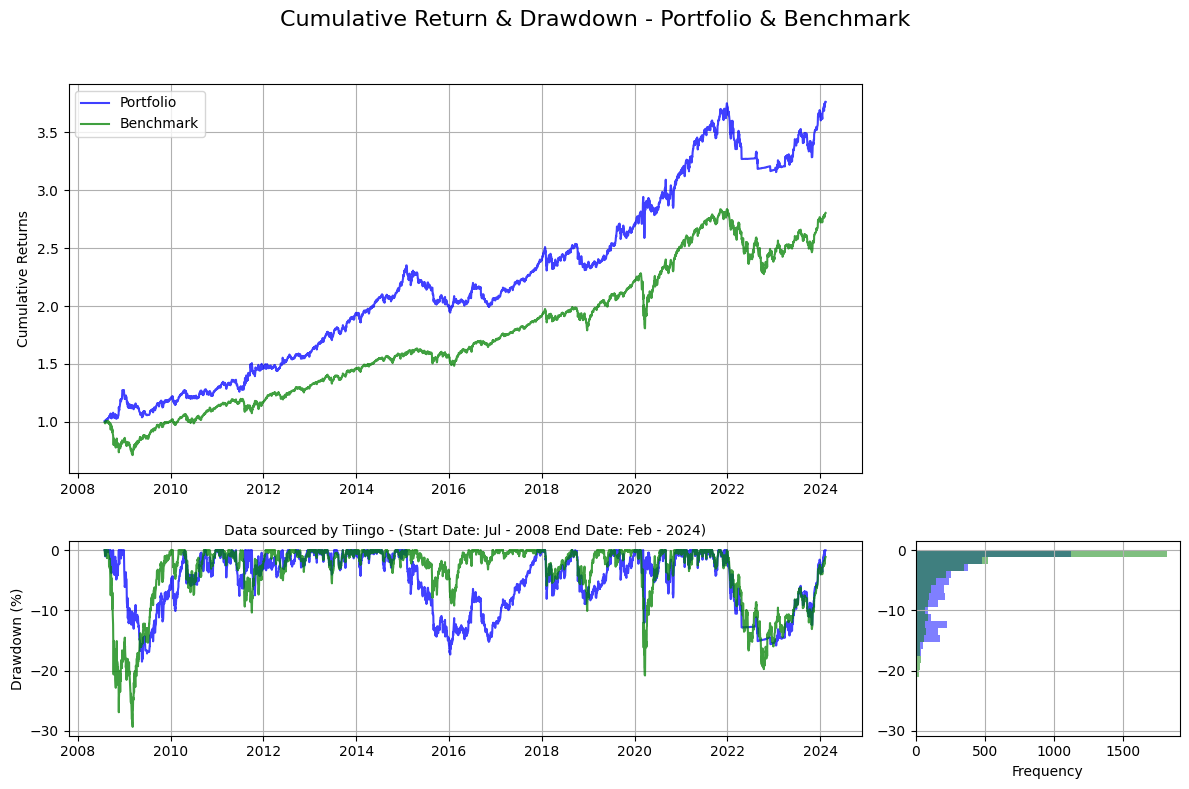

In [ ]:
create_cumula_rtn_drawdown_chart_function(svb_returns_df_cumualtive, svb_returns_df_drawdown)

##### Plot Strategy Rolling Volatility

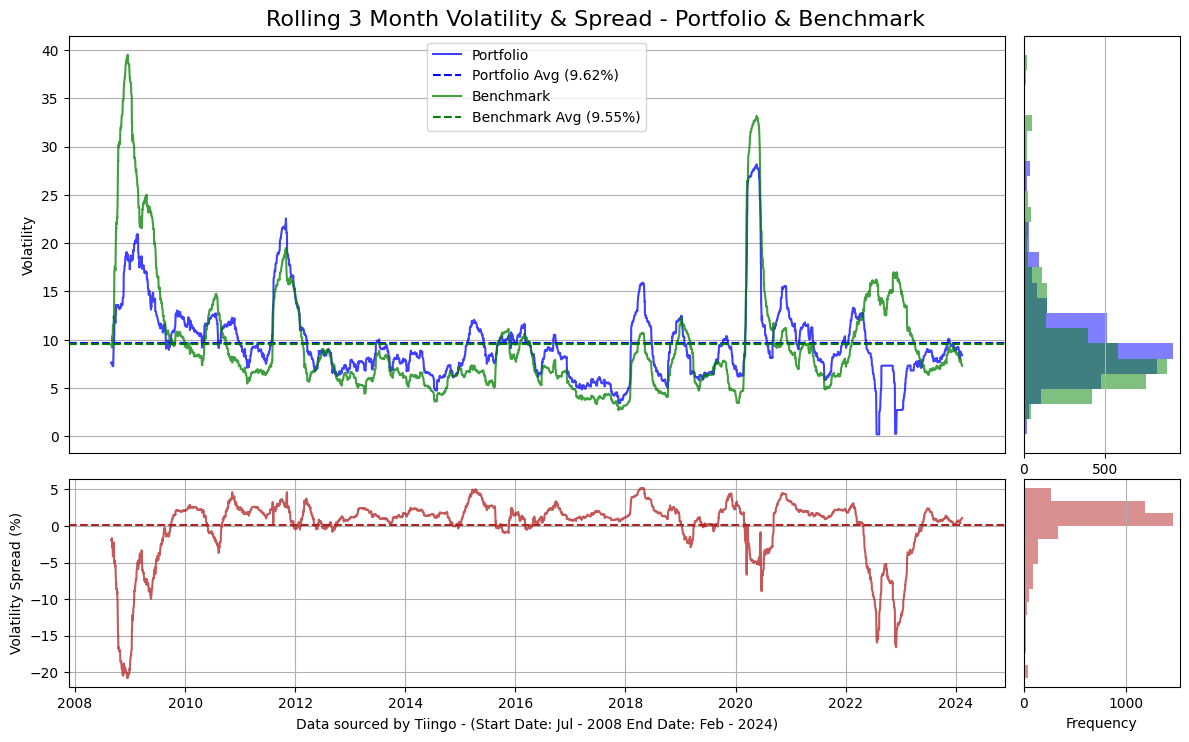

In [ ]:
create_rolling_volatility_chart_function(svb_bench_rtn)

##### Plot Strategy Monthly Returns

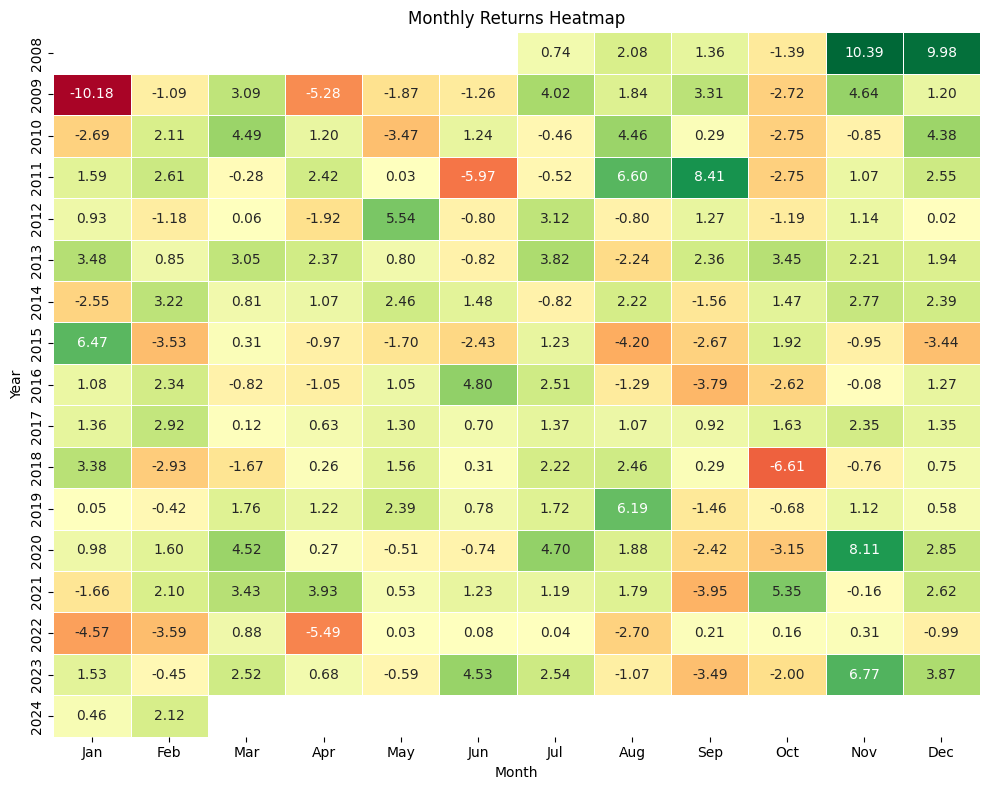

In [ ]:
plot_monthly_returns_heatmap(svb_bench_rtn['Portfolio'])

###**Strategy 2: Simple Asset Allocation**


#### Strategy 2 - Description



 Simple Asset Allocation (SAA1) calculates the momentum for the four assets; us stocks, int stocks, bonds & cash.

Simple asset allocation is very similar to the strategy outlined by Gary Antonacci's paper https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2042750

At the close on the last trading day of the month, measure the 12-month return of SPY (S&P 500), VEA (international equities).

If the return of SPY is greater than 0 (absolute momentum), go 100% long either SPY or VEA, depending on which has the highest return (relative momentum).

If the return of SPY is less than 0, go 100% long AGG ONLY if AGG has a positive momentum score, else allocate to cash.

#### Strategy 2 - Code

In [ ]:
# Simple Asset Allocation Function

def allocate_saa1_weights(momentum_score):
    # Define tickers for 'US Stocks', 'International Stocks', 'Bonds', & 'Cash'
    saa1_us_stocks = 'SPY'
    saa1_int_stocks = 'EFA'
    saa1_bonds = 'AGG'
    saa1_cash = 'BIL'

    # Filter ETF price history for the tickers selected
    saa1_ticker_list = [saa1_us_stocks, saa1_int_stocks, saa1_bonds, saa1_cash]
    saa1_rtn = etf_pct_returns[saa1_ticker_list]

    # Calculate the momentum score for the tickers
    saa1_mom_score = momentum_score[saa1_ticker_list]

    # Initialize weights DataFrame with zeros
    saa1_selection = pd.DataFrame(0, index=saa1_mom_score.index, columns=saa1_mom_score.columns)

    # Apply masking scheme for allocations based on momentum scores
    saa1_us_stock_mask = ((saa1_mom_score[saa1_us_stocks] > saa1_mom_score[saa1_cash]) & (saa1_mom_score[saa1_us_stocks] > saa1_mom_score[saa1_int_stocks]))
    saa1_int_stock_mask = ((saa1_mom_score[saa1_us_stocks] > saa1_mom_score[saa1_cash]) & (saa1_mom_score[saa1_int_stocks] > saa1_mom_score[saa1_us_stocks]))
    saa1_bond_mask = (((saa1_mom_score[saa1_us_stocks] < saa1_mom_score[saa1_cash])) & (saa1_mom_score[saa1_bonds] > saa1_mom_score[saa1_cash]))

    # Update selection DataFrame with masks
    saa1_selection[saa1_us_stocks] = saa1_us_stock_mask
    saa1_selection[saa1_int_stocks] = saa1_int_stock_mask
    saa1_selection[saa1_bonds] = saa1_bond_mask

    # Determine allocation for cash
    saa1_selection[saa1_cash] = 1 - saa1_selection[[saa1_us_stocks, saa1_int_stocks, saa1_bonds]].sum(axis=1)

    # Prepare weights for full momentum_score DataFrame size
    saa1_weights = momentum_score.copy()
    saa1_weights.loc[:, :] = 0  # Setting all values in 'svb_weights' to 0
    saa1_weights.update(saa1_selection)  # Updating with values from 'portfolio_selection'

    return saa1_weights


#### Strategy 2 - Analytics

##### Analytics Code

In [ ]:
saa1_weights = allocate_saa1_weights(momentum_score)
saa1_intra_month_weights = rebalance_portfolio_monthly(saa1_weights, etf_pct_returns)
saa1_returns = saa1_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

saa1_common_dates = saa1_intra_month_weights.index.intersection(etf_pct_returns.index)
saa1_filtered_dates = saa1_intra_month_weights[saa1_intra_month_weights.index.isin(saa1_common_dates)]
saa1_performance_df = saa1_filtered_dates.shift(1) * etf_pct_returns
saa1_performance_df_sum = saa1_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(svb_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

saa1_performance_df_sum = saa1_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
saa1_bench_rtn = pd.merge(saa1_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

saa1_returns_df_cumualtive = (1 + saa1_bench_rtn).cumprod()
saa1_returns_df_highwatermark = saa1_returns_df_cumualtive.cummax()
saa1_returns_df_drawdown = ((saa1_returns_df_cumualtive - saa1_returns_df_highwatermark) / saa1_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


##### Strategy Stats

In [ ]:
print(calculate_financial_metrics(saa1_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           159.65%   180.50%
CAGR                          6.33%     6.86%
Volatility                   12.86%    11.27%
Sharpe Ratio                   0.54      0.65
Sortino Ratio                  0.64      0.78
Max Drawdown                -24.36%   -29.36%
Longest Drawdown Duration       745       534
Skew                          -0.73     -0.29
Kurtosis                       4.16     11.78
1M Return                     3.75%     1.50%
3M Return                     9.59%     5.86%
1Y Return                     5.40%     1.65%
Best Day %                    4.40%     7.05%
Worst Day %                  -5.76%    -6.05%
Best Month %                 10.53%     7.49%
Worst Month %               -12.53%   -10.68%
Best Year %                  22.00%    19.78%
Worst Year %                -15.69%   -15.51%


##### Plot Strategy Cumulative Returns

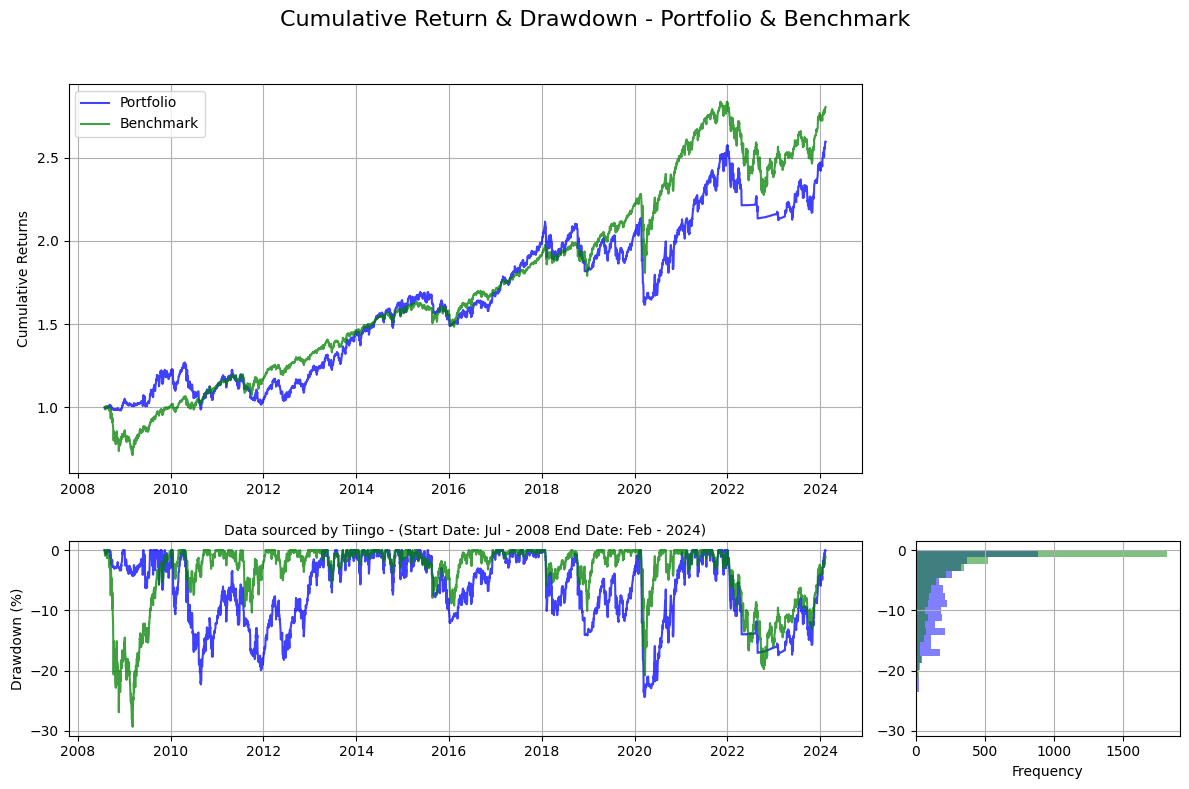

In [ ]:
create_cumula_rtn_drawdown_chart_function(saa1_returns_df_cumualtive, saa1_returns_df_drawdown)

##### Plot Strategy Rolling Volatility

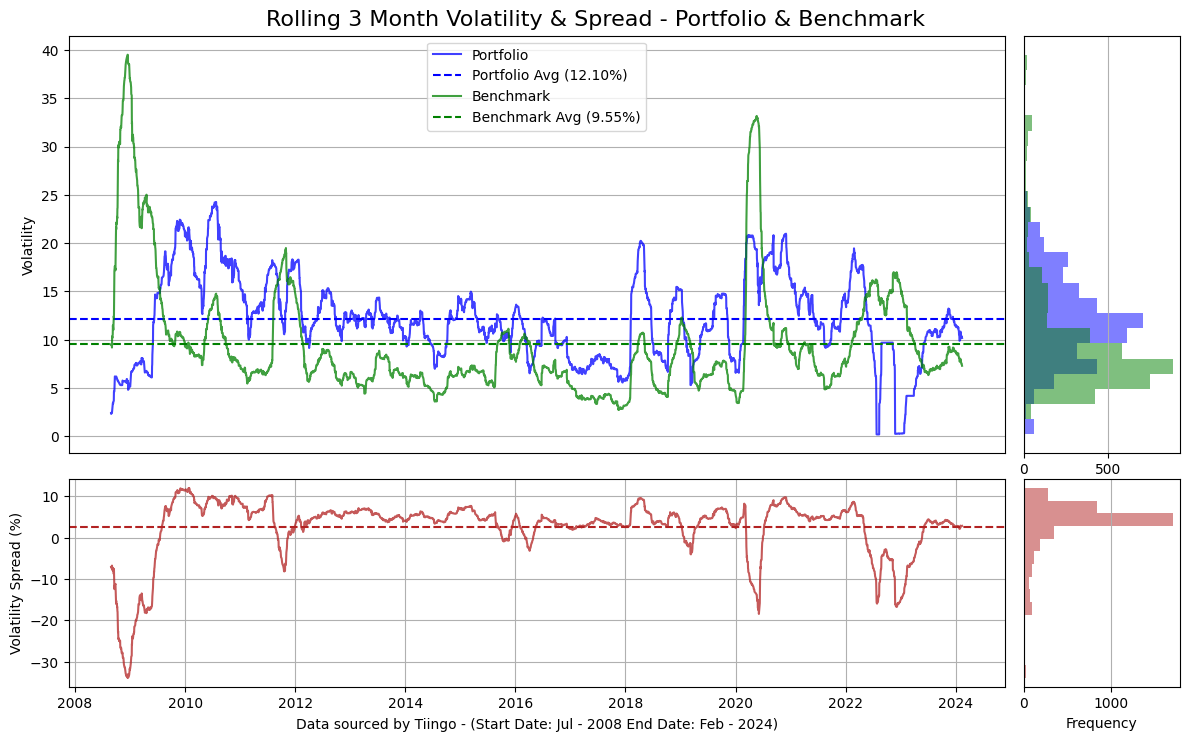

In [ ]:
create_rolling_volatility_chart_function(saa1_bench_rtn)

##### Plot Strategy Monthly Returns

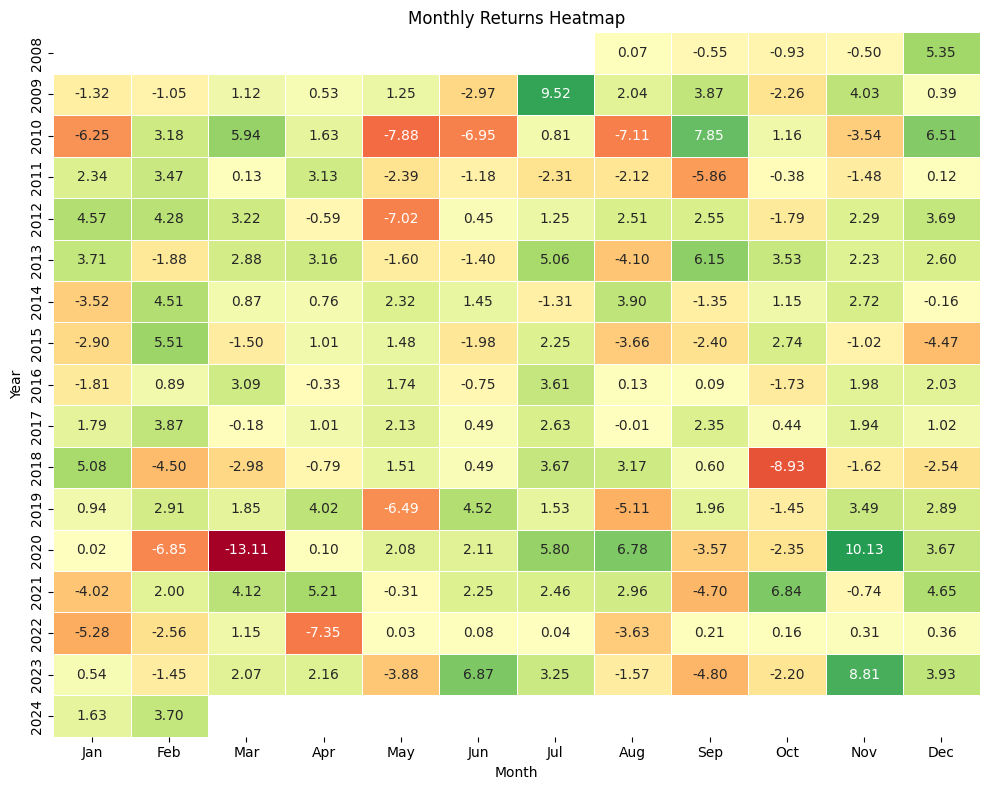

In [ ]:
plot_monthly_returns_heatmap(saa1_bench_rtn['Portfolio'])

###**Strategy 3: Hybrid Asset Allocation**



####Strategy 3 - Description

paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4346906

Strategy uses the trend of TIP ETF to determine if we are in a risk on or risk off environment.
If we are in a risk on environement it will then allocate equally to 4 of the highest ranking ETF's from a momentum perspective.
If we are in a risk off environment it will allocate to bonds if they have a positive momentum value, else it will allocate to cash.

Risk on universe is slightly different to the paper in that it contians QQQ rather than IWM.


####Strategy 3 - Code

In [ ]:
# Hybrid Asset Allocation Function

def hybrid_asset_allocation_function(momentum_score):
    defensive_assets = ['BIL', 'IEF']
    risky_assets = ['SPY', 'QQQ', 'VEA', 'VWO', 'VNQ', 'DBC', 'HYG', 'TLT']
    canary_asset = 'TIP'

    all_assets = defensive_assets + risky_assets + [canary_asset]
    haa_weights = pd.DataFrame(0, index=momentum_score.index, columns=all_assets)

    for date in momentum_score.index:
        current_momentum = momentum_score.loc[date]

        if current_momentum[canary_asset] <= 0:
            best_defensive = defensive_assets[current_momentum[defensive_assets].argmax()]
            haa_weights.loc[date, best_defensive] = 1.0
        else:
            # Sorting risky_assets based on their momentum scores and picking the top 4
            sorted_risky_assets = sorted(risky_assets, key=lambda x: current_momentum[x], reverse=True)[:4]
            for asset in sorted_risky_assets:
                haa_weights.loc[date, asset] = 1.0 / len(sorted_risky_assets)  # Evenly distribute among top 4 risky assets

        haa_weight_ = momentum_score.copy()
        haa_weight_.loc[:, :] = 0
        haa_weight_.update(haa_weights)  # Updating with values from 'portfolio_selection'

    return haa_weight_

####Strategy 3 - Analytics

#####Analytics Code

In [ ]:
haa_weights = hybrid_asset_allocation_function(momentum_score)
haa_intra_month_weights = rebalance_portfolio_monthly(haa_weights, etf_pct_returns)
haa_returns = haa_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

haa_common_dates = haa_intra_month_weights.index.intersection(etf_pct_returns.index)
haa_filtered_dates = haa_intra_month_weights[haa_intra_month_weights.index.isin(haa_common_dates)]
haa_performance_df = haa_filtered_dates.shift(1) * etf_pct_returns
haa_performance_df_sum = haa_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(haa_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

haa_performance_df_sum = haa_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
haa_bench_rtn = pd.merge(haa_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

haa_returns_df_cumualtive = (1 + haa_bench_rtn).cumprod()
haa_returns_df_highwatermark = haa_returns_df_cumualtive.cummax()
haa_returns_df_drawdown = ((haa_returns_df_cumualtive - haa_returns_df_highwatermark) / haa_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


#####Strategy Stats

In [ ]:
print(calculate_financial_metrics(haa_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           676.00%   180.50%
CAGR                         14.10%     6.86%
Volatility                   11.09%    11.27%
Sharpe Ratio                   1.25      0.65
Sortino Ratio                  1.47      0.78
Max Drawdown                -14.23%   -29.36%
Longest Drawdown Duration       314       534
Skew                          -0.33     -0.29
Kurtosis                       5.27     11.78
1M Return                     2.58%     1.50%
3M Return                     7.54%     5.86%
1Y Return                     2.39%     1.65%
Best Day %                    4.51%     7.05%
Worst Day %                  -4.07%    -6.05%
Best Month %                 10.51%     7.49%
Worst Month %                -7.92%   -10.68%
Best Year %                  39.16%    19.78%
Worst Year %                 -0.71%   -15.51%


##### Plot Strategy Cumulative Returns

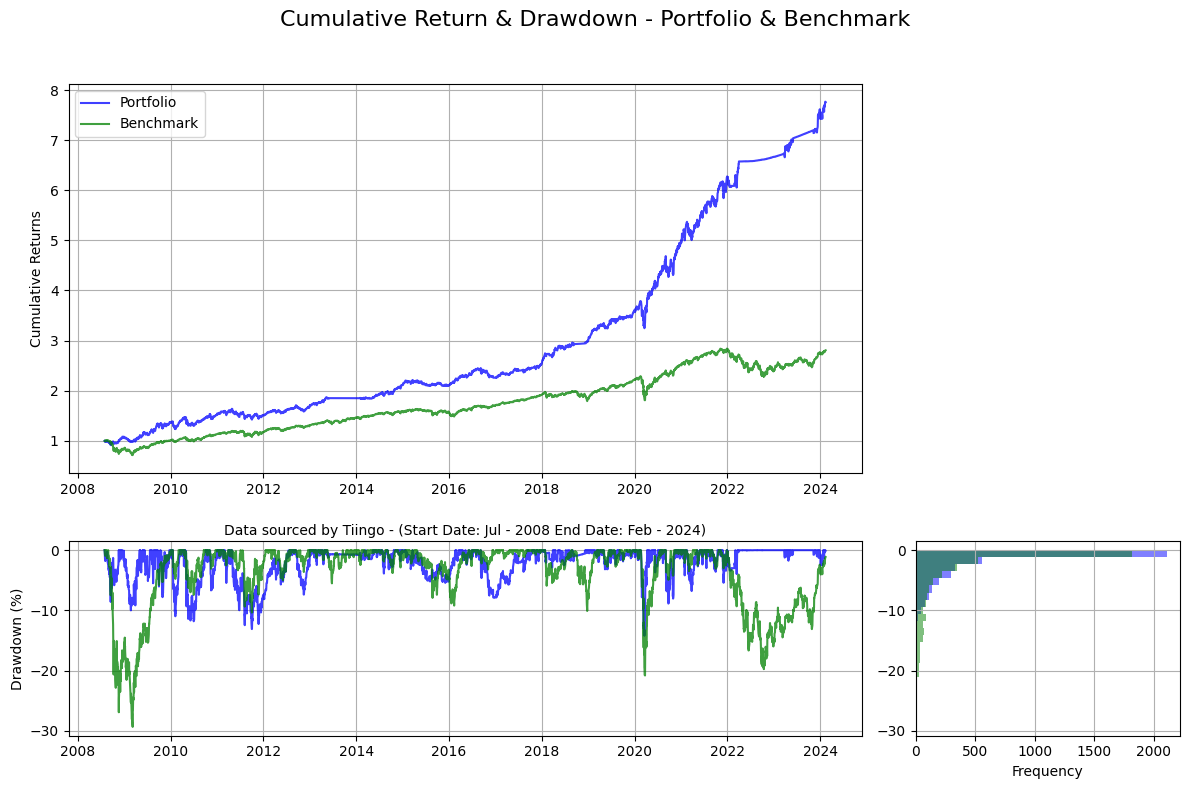

In [ ]:
create_cumula_rtn_drawdown_chart_function(haa_returns_df_cumualtive, haa_returns_df_drawdown)

##### Plot Strategy Rolling Volatility

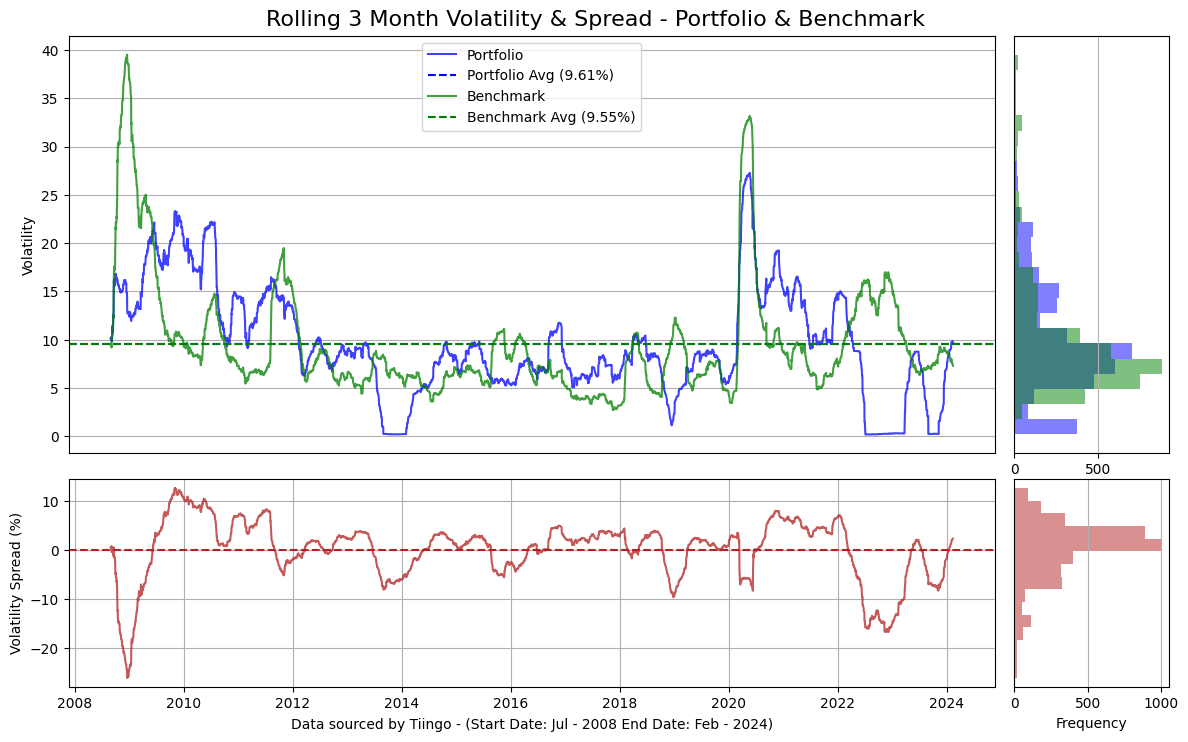

In [ ]:
create_rolling_volatility_chart_function(haa_bench_rtn)

#####Plot Strategy Monthly Returns

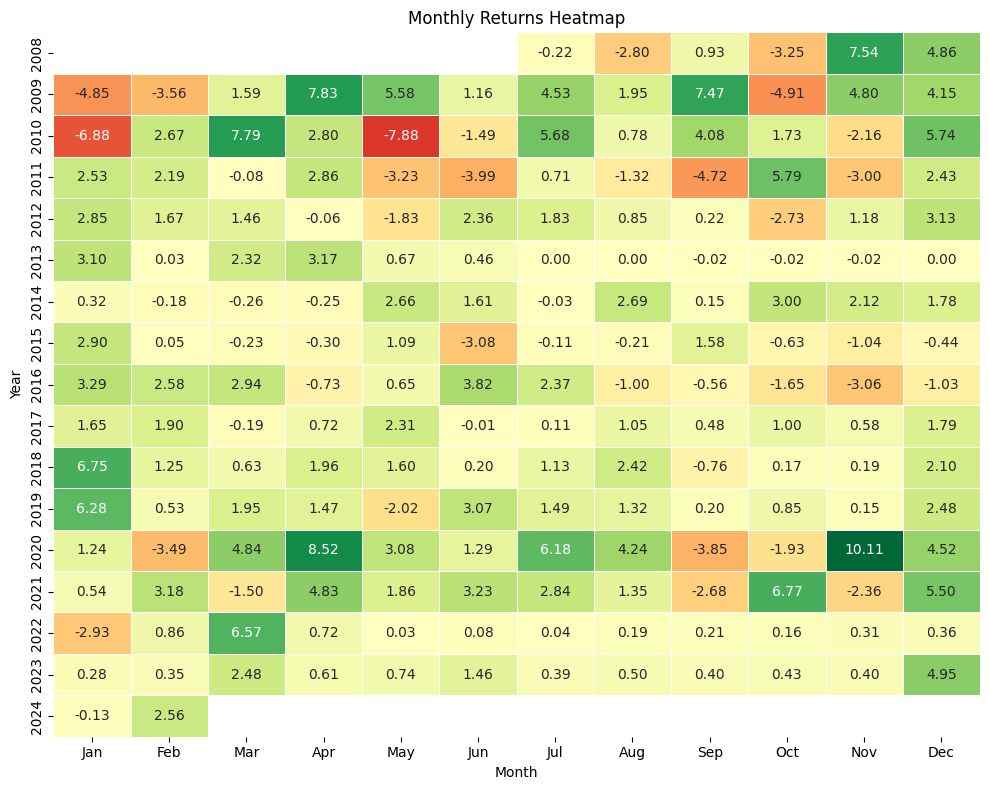

In [ ]:
plot_monthly_returns_heatmap(haa_bench_rtn['Portfolio'])

### **Strategy 4 - Dynamic Fixed Income**



####Strategy 4 - Description

TODO: Improve DFI


####Strategy 4 - Code

In [ ]:
def dynamic_fixed_income_function(momentum_score):

    # Initialize variables
    dfi_selection = pd.DataFrame(0., index=momentum_score.index, columns=momentum_score.columns)
    gov_fi = 0.25
    credit = 1 - gov_fi
    government_securities = ['SHY', 'IEF', 'TLT']
    credit_securities = ['LQD', 'HYG', 'AGG']

    # Apply gov_fi weights based on max momentum score for government securities
    max_gov_security = momentum_score[government_securities].idxmax(axis=1)
    for date, security in max_gov_security.items():
      if momentum_score.at[date, security] > 0:  # Only apply if momentum score is positive
        dfi_selection.at[date, security] = gov_fi

    # Rank credit securities and allocate
    ranking = momentum_score[credit_securities].rank(axis=1, ascending=False)
    for security in credit_securities:
        mask = ((ranking[security] < 2) & (momentum_score[security] > 0))
        dfi_selection.loc[mask, security] = credit

    # Allocate unallocated weights to BIL
    dfi_selection['BIL'] = 1 - dfi_selection.sum(axis=1)

    return dfi_selection

####Strategy 4 - Analytics

##### Analytics Code

In [ ]:
dfi_weights = dynamic_fixed_income_function(momentum_score)
dfi_intra_month_weights = rebalance_portfolio_monthly(dfi_weights, etf_pct_returns)
dfi_returns = dfi_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

dfi_common_dates = dfi_intra_month_weights.index.intersection(etf_pct_returns.index)
dfi_filtered_dates = dfi_intra_month_weights[dfi_intra_month_weights.index.isin(dfi_common_dates)]
dfi_performance_df = dfi_filtered_dates.shift(1) * etf_pct_returns
dfi_performance_df_sum = dfi_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(dfi_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

dfi_performance_df_sum = dfi_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
dfi_bench_rtn = pd.merge(dfi_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

dfi_returns_df_cumualtive = (1 + dfi_bench_rtn).cumprod()
dfi_weight_returns_df_highwatermark = dfi_returns_df_cumualtive.cummax()
dfi_returns_df_drawdown = ((dfi_returns_df_cumualtive - dfi_weight_returns_df_highwatermark) / dfi_weight_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


#####Strategy Stats

In [ ]:
print(calculate_financial_metrics(dfi_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return            56.38%   180.50%
CAGR                          2.92%     6.86%
Volatility                    6.01%    11.27%
Sharpe Ratio                   0.51      0.65
Sortino Ratio                  0.62      0.78
Max Drawdown                -13.08%   -29.36%
Longest Drawdown Duration       990       534
Skew                          -0.81     -0.29
Kurtosis                      11.39     11.78
1M Return                    -0.22%     1.50%
3M Return                     1.03%     5.86%
1Y Return                    -1.08%     1.65%
Best Day %                    2.90%     7.05%
Worst Day %                  -4.28%    -6.05%
Best Month %                  7.43%     7.49%
Worst Month %                -5.57%   -10.68%
Best Year %                  12.62%    19.78%
Worst Year %                 -6.79%   -15.51%


##### Plot Strategy Cumulative Returns

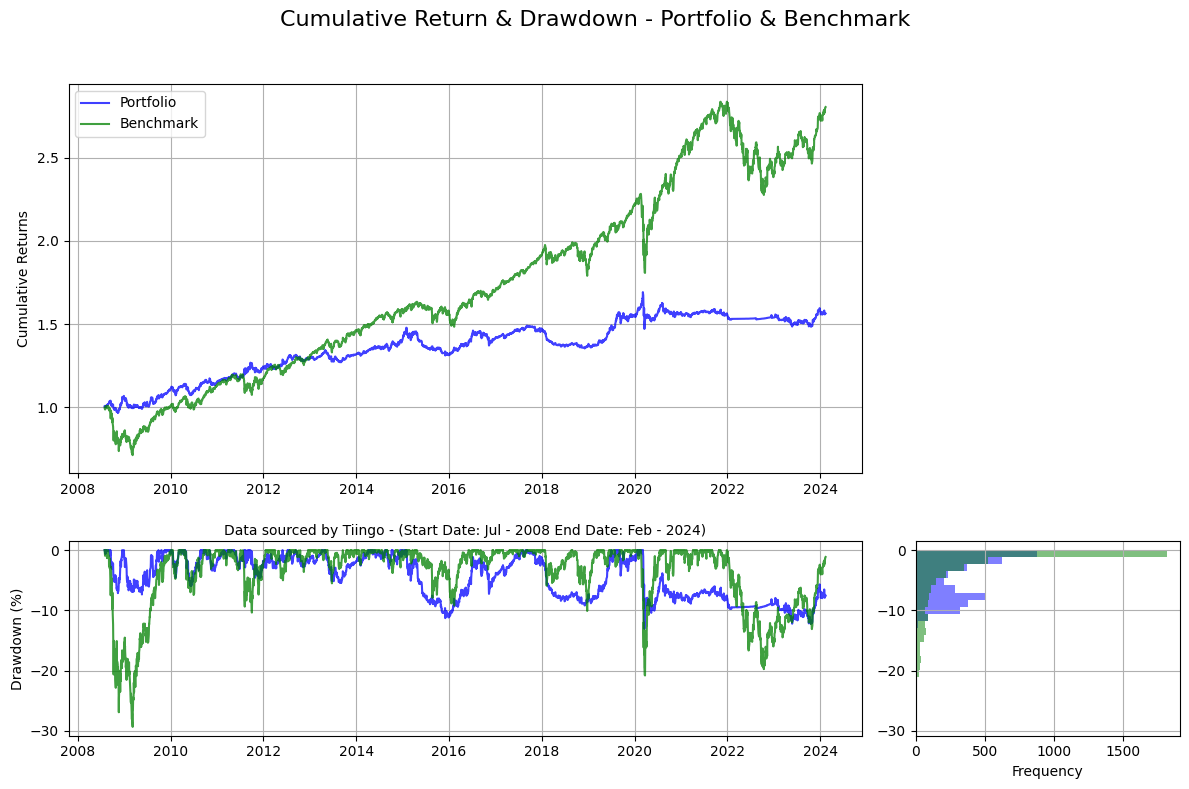

In [ ]:
create_cumula_rtn_drawdown_chart_function(dfi_returns_df_cumualtive, dfi_returns_df_drawdown)

##### Plot Strategy Rolling Volatility

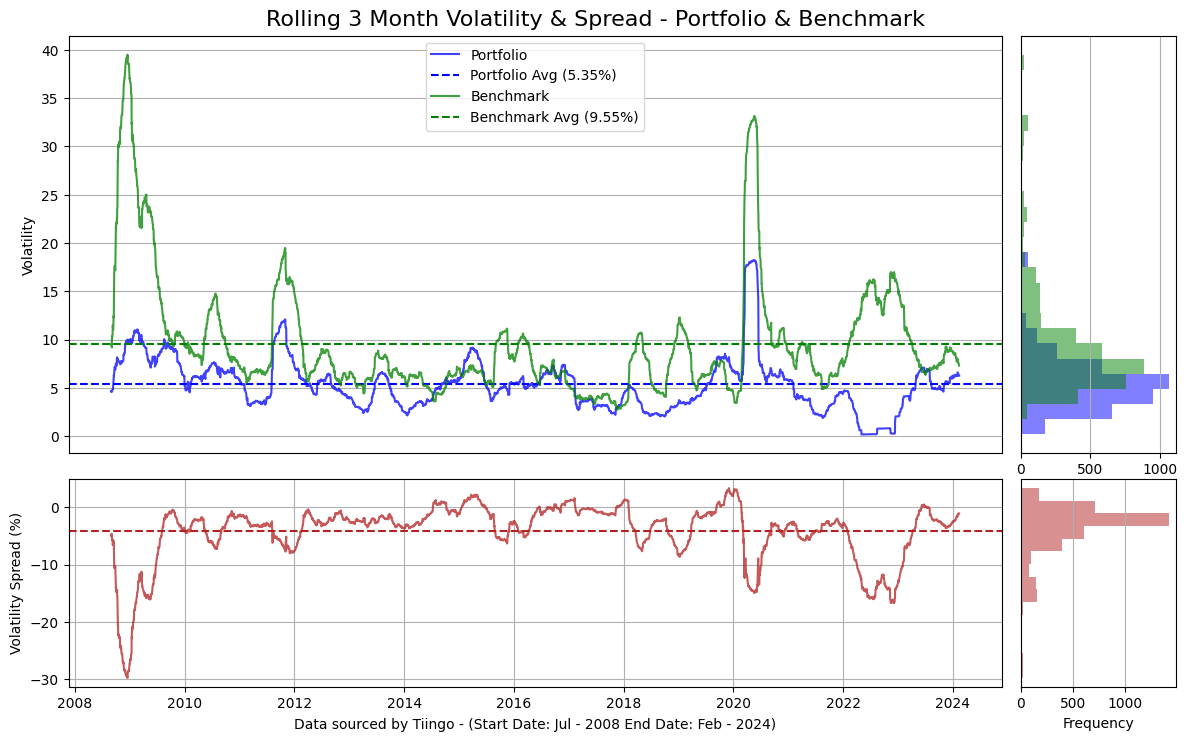

In [ ]:
create_rolling_volatility_chart_function(dfi_bench_rtn)

##### Plot Strategy Monthly Returns

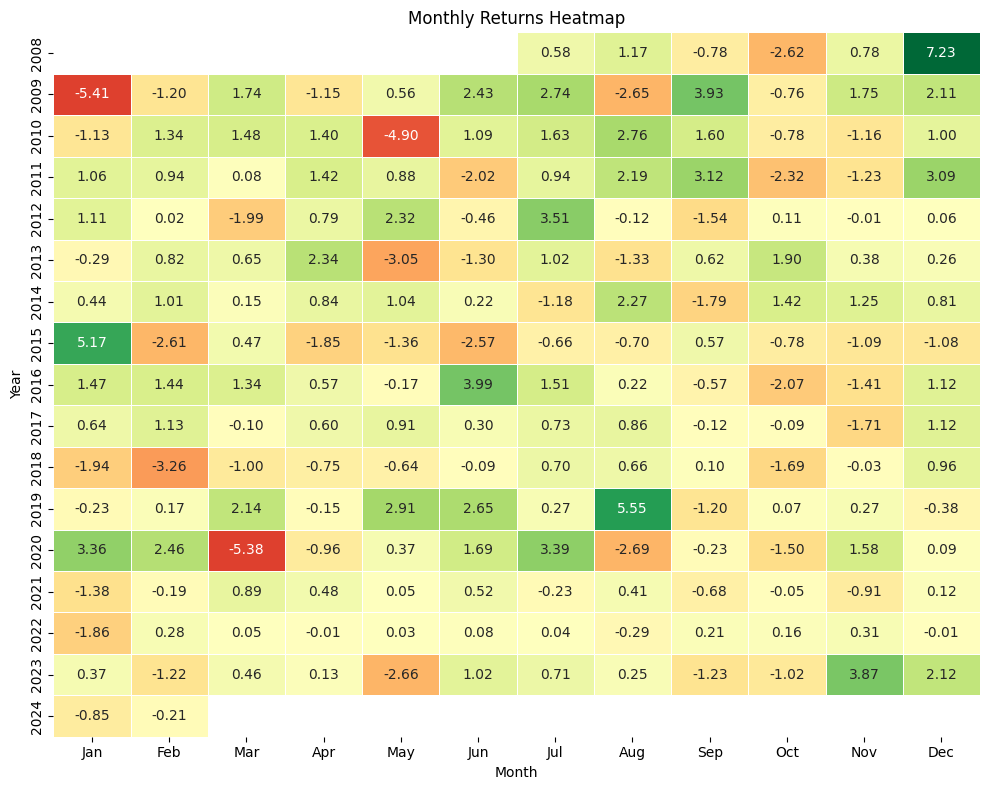

In [ ]:
plot_monthly_returns_heatmap(dfi_bench_rtn['Portfolio'])

### **Strategy 5 - Sector Allocation**


####Strategy 5 - Description

The strategy below looks to implement the strategy outlined in the following blog post. I have not included Communication Services (XLC), Real Estate (XLRE) due to these ETFs having a different inception date to the others. This strategy is similar to the code used in HAA using a canary signal. This strategy then invests equally in the top 3 assets (unlike HAA which invests equally in the top 4 assets)
https://nlxfinance.wordpress.com/2023/11/22/simulation-of-gary-antonaccis-dual-momentum-sector-rotation-strategy/

####Strategy 5 - Code

In [ ]:
def dual_mom_sector_function(momentum_score):
    defensive_assets = ['BIL', 'IEF']
    risky_assets = ['XLP', 'XLE', 'XLF', 'XLV', 'XLI', 'XLK', 'XLB', 'XLU', 'XLY']
    canary_asset = 'SPY'

    all_assets = defensive_assets + risky_assets + [canary_asset]
    dmsf_weight_ = pd.DataFrame(0, index=momentum_score.index, columns=all_assets)

    for date in momentum_score.index:
        current_momentum = momentum_score.loc[date]

        if current_momentum[canary_asset] <= 0:
            best_defensive = defensive_assets[current_momentum[defensive_assets].argmax()]
            dmsf_weight_.loc[date, best_defensive] = 1.0
        else:
            # Sorting risky_assets based on their momentum scores and picking the top 3
            sorted_risky_assets = sorted(risky_assets, key=lambda x: current_momentum[x], reverse=True)[:3]
            for asset in sorted_risky_assets:
                dmsf_weight_.loc[date, asset] = 1.0 / len(sorted_risky_assets)  # Evenly distribute among top 3 risky assets

        dual_weight = momentum_score.copy()
        dual_weight.loc[:, :] = 0
        dual_weight.update(dmsf_weight_)  # Updating with values from 'portfolio_selection'

    return dual_weight


####Strategy 5 - Analytics

##### Analytics Code

In [ ]:
sec_weights = dual_mom_sector_function(momentum_score)
sec_intra_month_weights = rebalance_portfolio_monthly(sec_weights, etf_pct_returns)
sec_returns = sec_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

sec_common_dates = sec_intra_month_weights.index.intersection(etf_pct_returns.index)
sec_filtered_dates = sec_intra_month_weights[sec_intra_month_weights.index.isin(sec_common_dates)]
sec_performance_df = sec_filtered_dates.shift(1) * etf_pct_returns
sec_performance_df_sum = sec_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(sec_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

sec_performance_df_sum = sec_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
sec_bench_rtn = pd.merge(sec_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

sec_returns_df_cumualtive = (1 + sec_bench_rtn).cumprod()
sec_returns_df_highwatermark = sec_returns_df_cumualtive.cummax()
sec_returns_df_drawdown = ((sec_returns_df_cumualtive - sec_returns_df_highwatermark) / sec_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


##### Strategy Stats

In [ ]:
print(calculate_financial_metrics(sec_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           473.97%   180.50%
CAGR                         11.91%     6.86%
Volatility                   13.67%    11.27%
Sharpe Ratio                   0.89      0.65
Sortino Ratio                  1.15      0.78
Max Drawdown                -23.97%   -29.36%
Longest Drawdown Duration       468       534
Skew                          -0.41     -0.29
Kurtosis                       3.57     11.78
1M Return                     3.72%     1.50%
3M Return                     8.57%     5.86%
1Y Return                     3.49%     1.65%
Best Day %                    5.51%     7.05%
Worst Day %                  -6.23%    -6.05%
Best Month %                 10.05%     7.49%
Worst Month %               -10.03%   -10.68%
Best Year %                  39.77%    19.78%
Worst Year %                 -8.46%   -15.51%


##### Plot Strategy Cumulative Returns

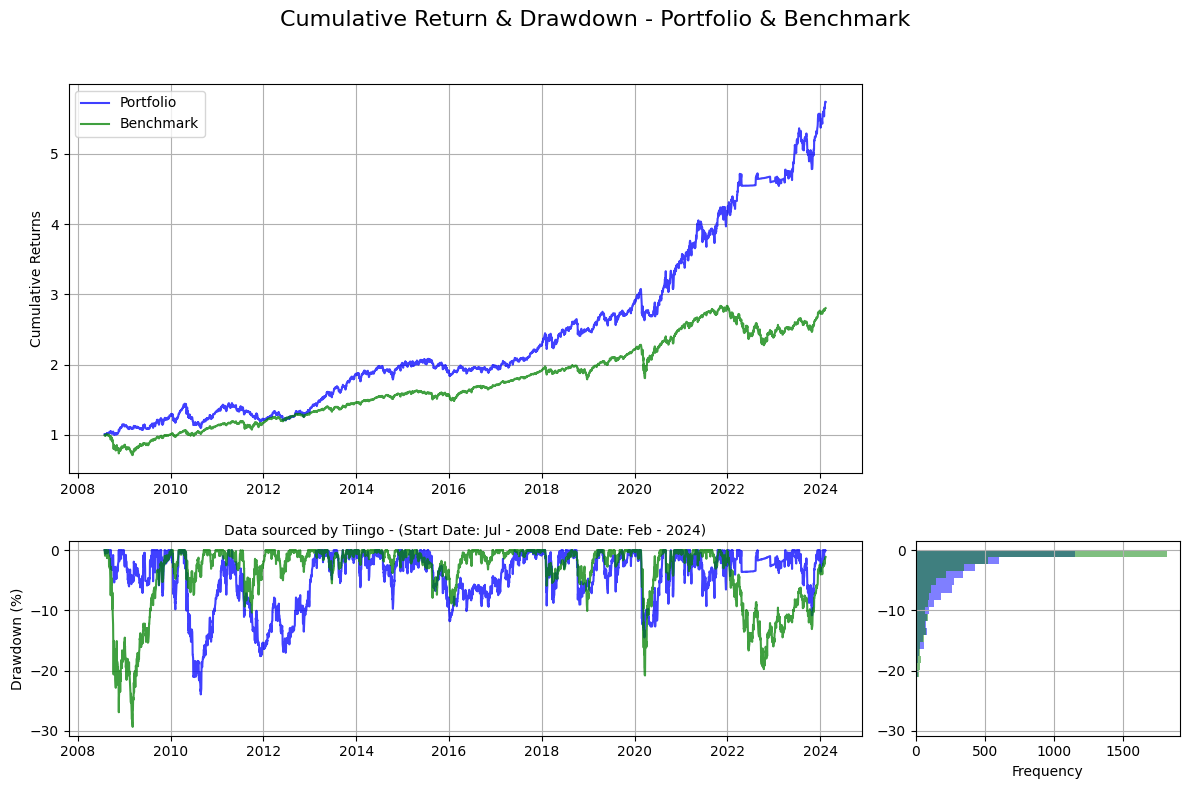

In [ ]:
create_cumula_rtn_drawdown_chart_function(sec_returns_df_cumualtive, sec_returns_df_drawdown)

##### Plot Strategy Rolling Volatility

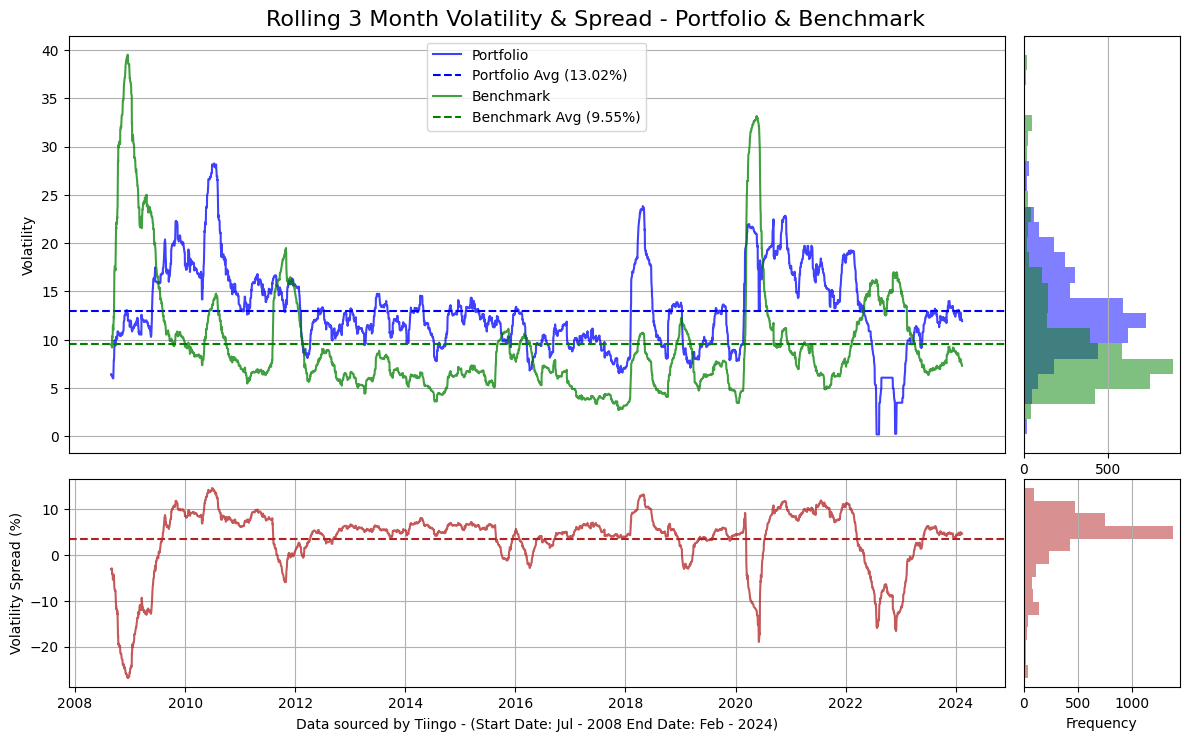

In [ ]:
create_rolling_volatility_chart_function(sec_bench_rtn)

##### Plot Strategy Monthly Returns

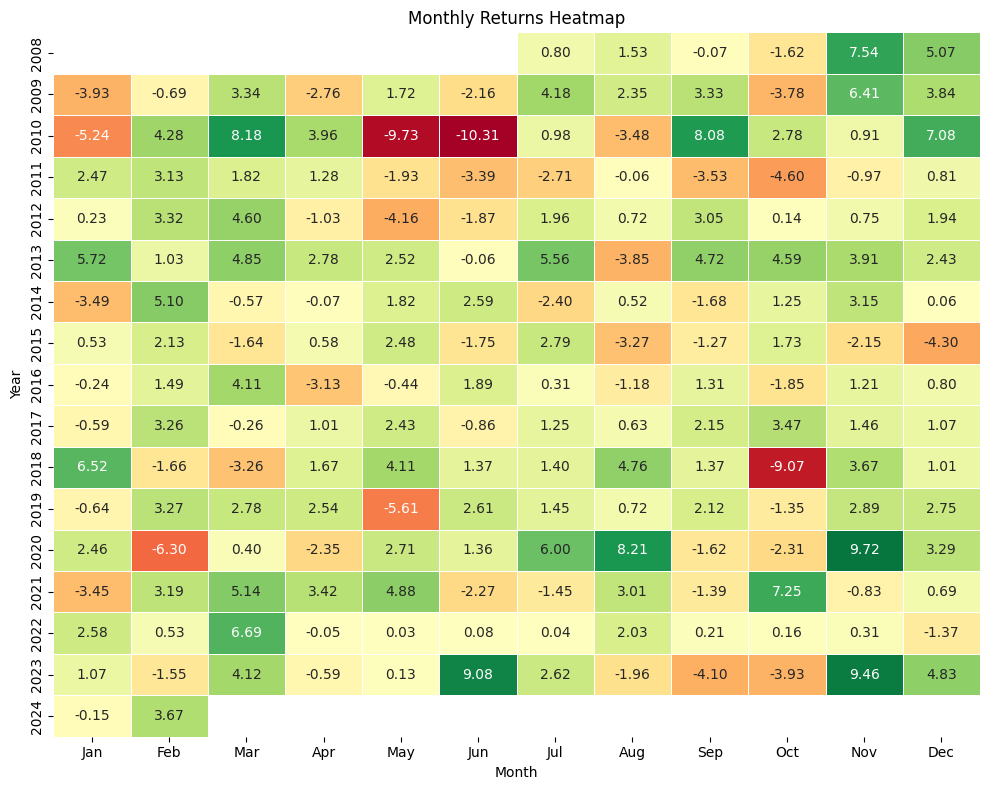

In [ ]:
plot_monthly_returns_heatmap(sec_bench_rtn['Portfolio'])

### **Strategy 6 - Timed Beta**

####Strategy 6 - Description

Stategy 6 applies the momentum filtering on a very basic 'Global Market Portfolio' introduced Doeswijk et al https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2352932. Any allocations not allocated will be allocated to cash.

####Strategy 6 - Code

In [ ]:
def timed_beta_weight_function(momentum_score):
    dm_equity_weight = 0.45
    em_equity_weight = 0.05
    comdty_weight = 0.02
    reit_weight = 0.03
    credit_weight = 0.15
    duration_bond_weight = 0.1
    short_bond_weight = 0.2

    # Create a DataFrame with the same shape as momentum_score
    weight_df = pd.DataFrame(0, index=momentum_score.index, columns=momentum_score.columns)

    # Apply boolean logic to adjust the weights based on momentum score
    weight_df['SPY'] = momentum_score['SPY'].apply(lambda x: dm_equity_weight if x > 0 else 0)
    weight_df['EEM'] = momentum_score['EEM'].apply(lambda x: em_equity_weight if x > 0 else 0)
    weight_df['DBC'] = momentum_score['DBC'].apply(lambda x: comdty_weight if x > 0 else 0)
    weight_df['VNQ'] = momentum_score['VNQ'].apply(lambda x: reit_weight if x > 0 else 0)
    weight_df['LQD'] = momentum_score['LQD'].apply(lambda x: credit_weight if x > 0 else 0)
    weight_df['TLT'] = momentum_score['TLT'].apply(lambda x: duration_bond_weight if x > 0 else 0)
    weight_df['IEF'] = momentum_score['IEF'].apply(lambda x: short_bond_weight if x > 0 else 0)
    weight_df['BIL'] = 1 - weight_df[['SPY', 'EEM', 'DBC', 'VNQ', 'LQD', 'TLT', 'IEF']].sum(axis=1)

    return weight_df



####Strategy 6 - Analytics

#####Analytics Code

In [ ]:
tbeta_weights = timed_beta_weight_function(momentum_score)
tbeta_intra_month_weights = rebalance_portfolio_monthly(tbeta_weights, etf_pct_returns)
tbeta_returns = tbeta_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

tbeta_common_dates = tbeta_intra_month_weights.index.intersection(etf_pct_returns.index)
tbeta_filtered_dates = tbeta_intra_month_weights[tbeta_intra_month_weights.index.isin(tbeta_common_dates)]
tbeta_performance_df = tbeta_filtered_dates.shift(1) * etf_pct_returns
tbeta_performance_df_sum = tbeta_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(tbeta_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

tbeta_performance_df_sum = tbeta_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
tbeta_bench_rtn = pd.merge(tbeta_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

tbeta_returns_df_cumualtive = (1 + tbeta_bench_rtn).cumprod()
tbeta_returns_df_highwatermark = tbeta_returns_df_cumualtive.cummax()
tbeta_returns_df_drawdown = ((tbeta_returns_df_cumualtive - tbeta_returns_df_highwatermark) / tbeta_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


#####Strategy Stats

In [ ]:
print(calculate_financial_metrics(tbeta_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           152.96%   180.50%
CAGR                          6.16%     6.86%
Volatility                    6.31%    11.27%
Sharpe Ratio                   0.98      0.65
Sortino Ratio                  1.25      0.78
Max Drawdown                 -9.11%   -29.36%
Longest Drawdown Duration       526       534
Skew                          -0.51     -0.29
Kurtosis                       3.33     11.78
1M Return                     0.93%     1.50%
3M Return                     4.58%     5.86%
1Y Return                     0.91%     1.65%
Best Day %                    2.16%     7.05%
Worst Day %                  -3.05%    -6.05%
Best Month %                  6.24%     7.49%
Worst Month %                -4.11%   -10.68%
Best Year %                  14.61%    19.78%
Worst Year %                 -8.48%   -15.51%


#####Plot Strategy Cumulative Return

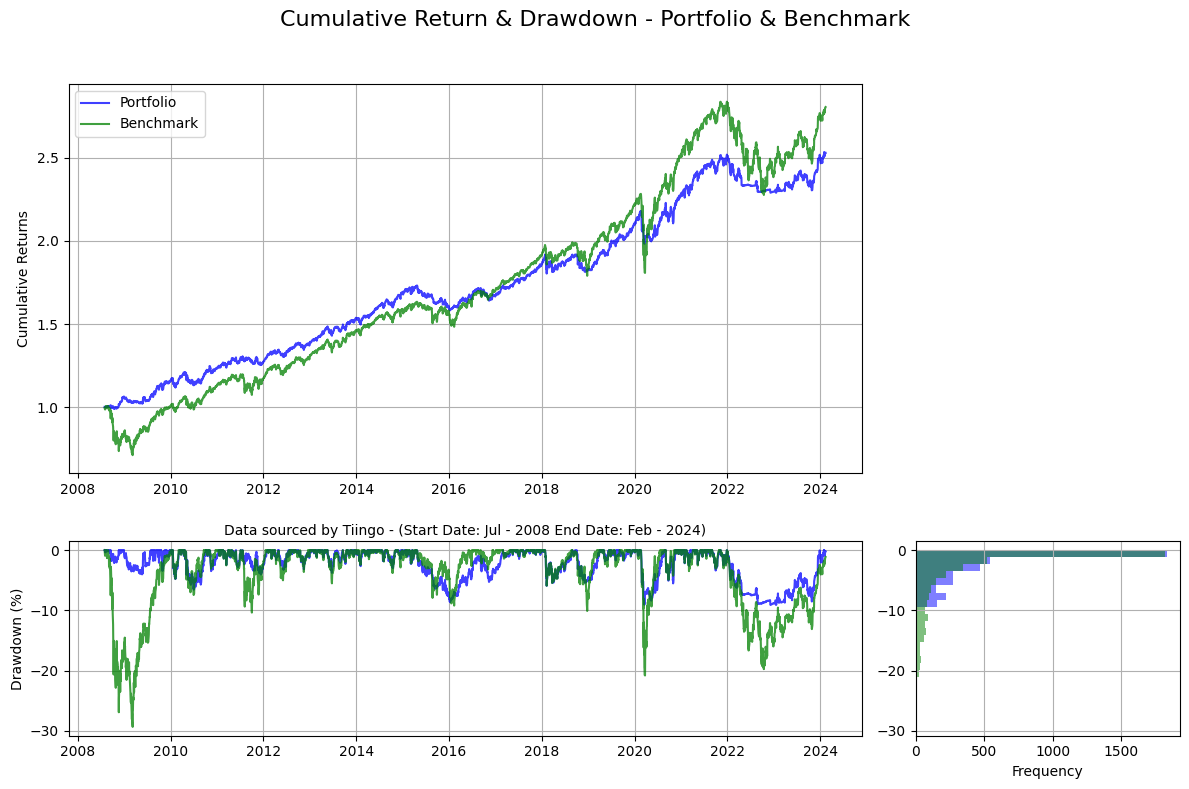

In [ ]:
create_cumula_rtn_drawdown_chart_function(tbeta_returns_df_cumualtive, tbeta_returns_df_drawdown)

#####Plot Strategy Rolling Volatility

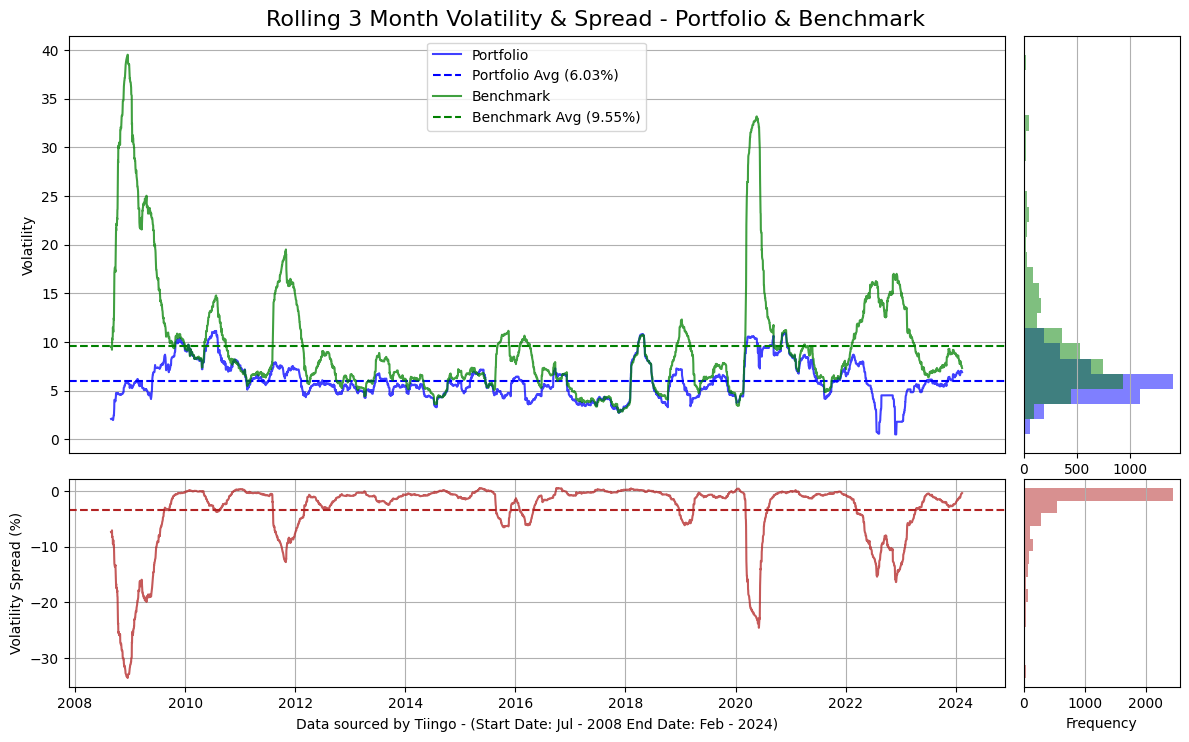

In [ ]:
create_rolling_volatility_chart_function(tbeta_bench_rtn)

#####Plot Strategy Monthly Returns

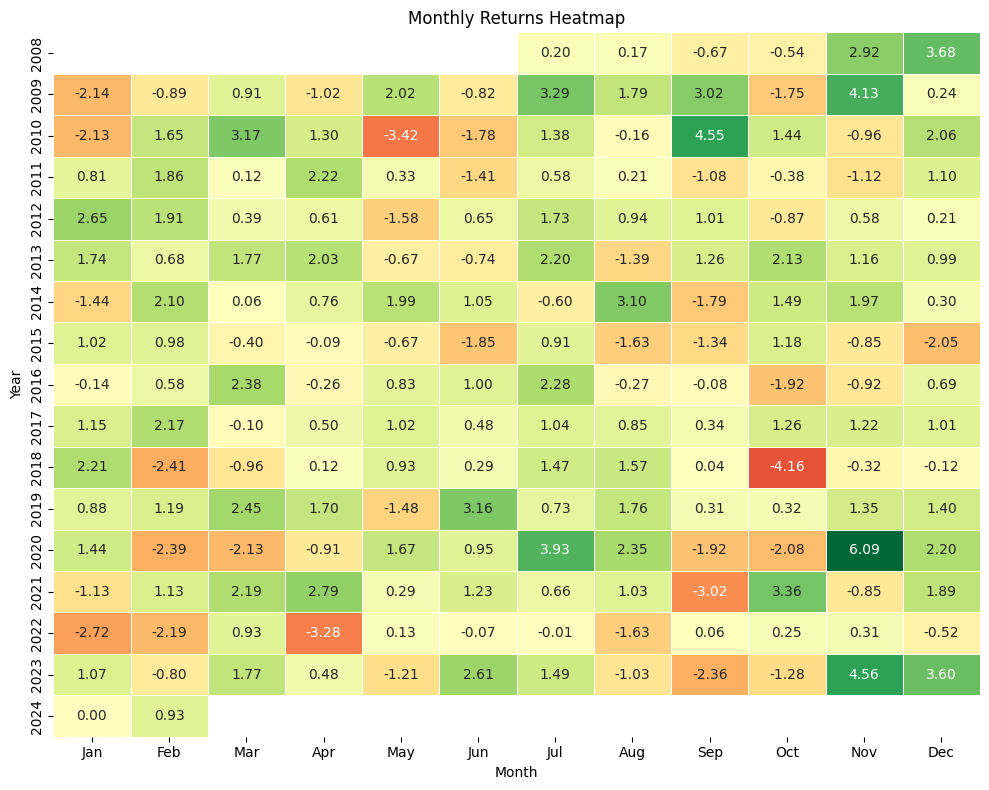

In [ ]:
plot_monthly_returns_heatmap(tbeta_bench_rtn['Portfolio'])

###**Strategy 7 - Vigilant Asset Allocation**


####Strategy 7 - Description

Replication of the VAA Strategy introduced in the following paper https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3002624

####Strategy 7 - Code

In [ ]:
def vaa_strategy_weight_function(momentum_score):
    # Create a DataFrame to store strategy weights
    strategy_weights = pd.DataFrame(0, index=momentum_score.index, columns=momentum_score.columns)

    # Define offensive and defensive assets
    offensive_assets = ['SPY','QQQ', 'VEA', 'AGG']
    defensive_assets = ['IEF', 'SHY', 'BIL']

    # Iterate through each day to calculate weights
    for i in range(len(momentum_score)):
        # Separate offensive and defensive scores for the current day
        offensive_scores = momentum_score.loc[momentum_score.index[i], offensive_assets]
        defensive_scores = momentum_score.loc[momentum_score.index[i], defensive_assets]

        # Check if all offensive assets have positive momentum
        if all(offensive_scores > 0):
            # Offensive mode: select asset with highest positive momentum score
            selected_asset = offensive_scores.idxmax()
        else:
            # Defensive mode: select defensive asset with highest score
            selected_asset = defensive_scores.idxmax()

        # Allocate 100% to the selected asset
        strategy_weights.at[momentum_score.index[i], selected_asset] = 1

    return strategy_weights


####Strategy 7 - Analytics

#####Analytics Code

In [ ]:
vaa_weights = vaa_strategy_weight_function(momentum_score)
vaa_intra_month_weights = rebalance_portfolio_monthly(vaa_weights, etf_pct_returns)
vaa_returns = vaa_intra_month_weights.shift(1) * etf_pct_returns
benchmark_weights = benchmark_weight_function(momentum_score)
benchmark_intra_month_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)
benchmark_rtn = benchmark_intra_month_weights * etf_pct_returns

vaa_common_dates = vaa_intra_month_weights.index.intersection(etf_pct_returns.index)
vaa_filtered_dates = vaa_intra_month_weights[vaa_intra_month_weights.index.isin(vaa_common_dates)]
vaa_performance_df = vaa_filtered_dates.shift(1) * etf_pct_returns
vaa_performance_df_sum = vaa_performance_df.sum(axis=1)

bench_common_dates = benchmark_intra_month_weights.index.intersection(etf_pct_returns.index)
bench_filtered_dates = benchmark_intra_month_weights[benchmark_intra_month_weights.index.isin(haa_common_dates)]
bench_performance_df = bench_filtered_dates.shift(1) * etf_pct_returns
bench_performance_df_sum = bench_performance_df.sum(axis=1)

vaa_performance_df_sum = vaa_performance_df_sum.rename('Portfolio')
bench_performance_df_sum = bench_performance_df_sum.rename('Benchmark')
vaa_bench_rtn = pd.merge(vaa_performance_df_sum, bench_performance_df_sum, left_index=True, right_index=True, how='inner').iloc[1:]

vaa_returns_df_cumualtive = (1 + vaa_bench_rtn).cumprod()
vaa_returns_df_highwatermark = vaa_returns_df_cumualtive.cummax()
vaa_returns_df_drawdown = ((vaa_returns_df_cumualtive - vaa_returns_df_highwatermark) / vaa_returns_df_highwatermark) * 100

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


#####Strategy Stats

In [ ]:
print(calculate_financial_metrics(vaa_bench_rtn))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           598.56%   180.50%
CAGR                         13.33%     6.86%
Volatility                   11.13%    11.27%
Sharpe Ratio                   1.18      0.65
Sortino Ratio                  1.31      0.78
Max Drawdown                -12.88%   -29.36%
Longest Drawdown Duration       570       534
Skew                          -0.57     -0.29
Kurtosis                       6.35     11.78
1M Return                     4.41%     1.50%
3M Return                    11.95%     5.86%
1Y Return                     6.30%     1.65%
Best Day %                    4.46%     7.05%
Worst Day %                  -5.07%    -6.05%
Best Month %                 11.23%     7.49%
Worst Month %                -6.88%   -10.68%
Best Year %                  41.48%    19.78%
Worst Year %                 -0.94%   -15.51%


#####Plot Strategy Cumulative Return

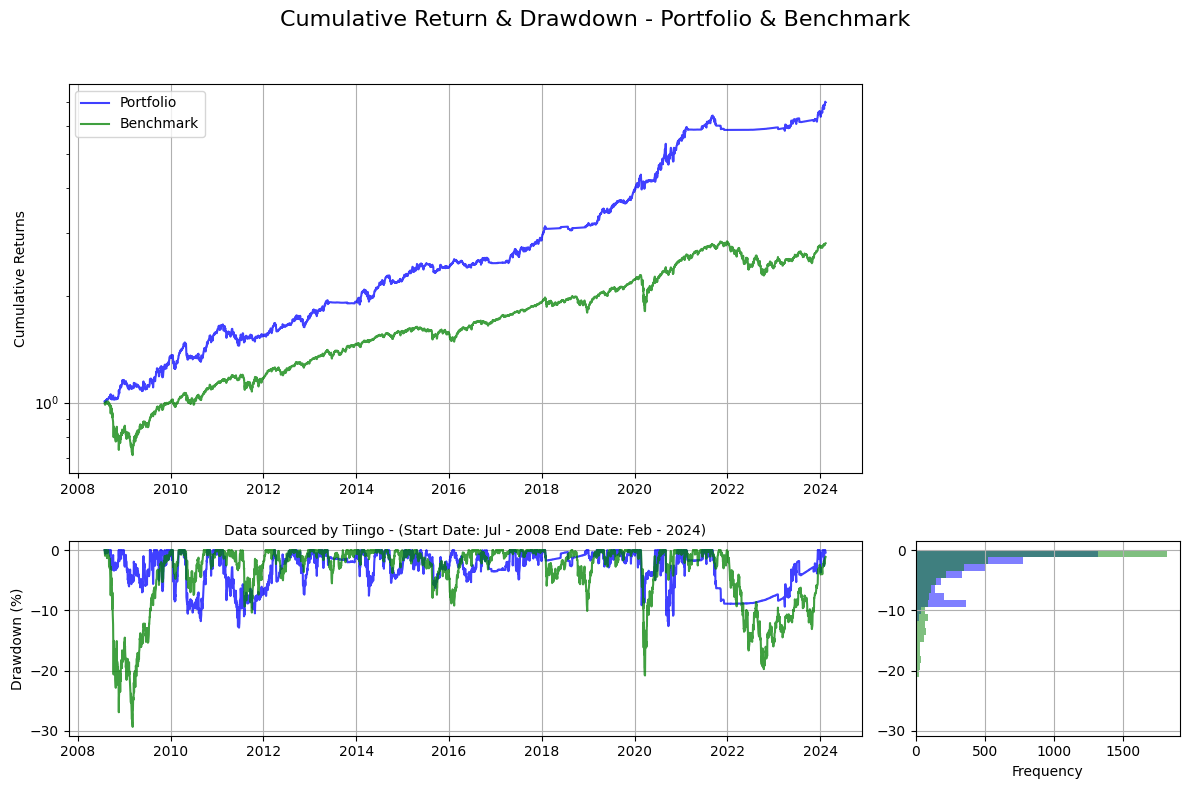

In [ ]:
create_cumula_rtn_drawdown_chart_function(vaa_returns_df_cumualtive, vaa_returns_df_drawdown)

#####Plot Strategy Rolling Volatility

#####Plot Strategy Monthly Returns

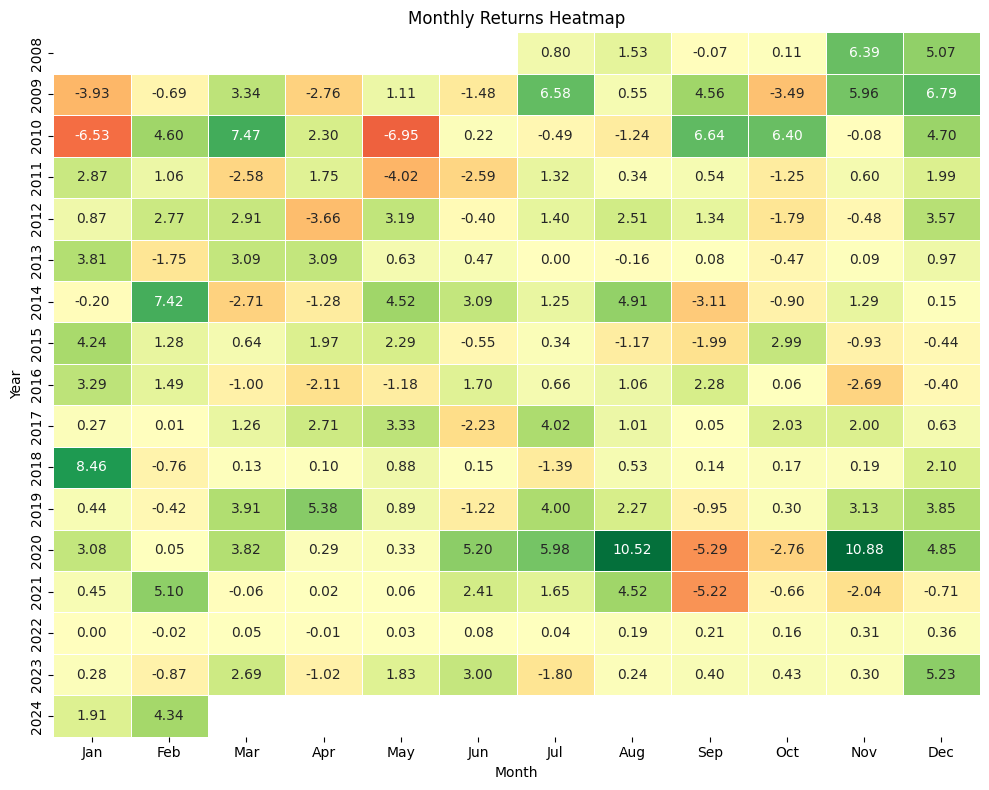

In [ ]:
plot_monthly_returns_heatmap(vaa_bench_rtn['Portfolio'])

# **Portfolio Weighting & Rebalancing**

### Strategy Weights

In [ ]:
# Add desired strategy weights
strategy_weight_svb = 1/6
strategy_weight_saa1 = 1/6
strategy_weight_haa = 1/6
strategy_weight_dfi = 1/6
strategy_weight_sector = 1/6
strategy_weight_timed_beta = 0
strategy_weight_vaa = 1/6

In [ ]:
# Weights Calculation
stock_versus_bonds_weight = stocks_v_bonds(momentum_score)
haa_weights_df = hybrid_asset_allocation_function(momentum_score)
saa1_weight = allocate_saa1_weights(mom_12m)
dfi_weight = dynamic_fixed_income_function(momentum_score)
sector_weight = dual_mom_sector_function(momentum_score)
vaa_weight = vaa_strategy_weight_function(momentum_score)
timed_beta_weight = timed_beta_weight_function(momentum_score)


# Overall Weights
overall_weight = (
    (stock_versus_bonds_weight * strategy_weight_svb) +
    (saa1_weight * strategy_weight_saa1) +
    ( haa_weights_df * strategy_weight_haa) +
    (dfi_weight * strategy_weight_dfi) +
    (sector_weight * strategy_weight_sector) +
    (vaa_weight * strategy_weight_vaa) +
    (timed_beta_weight * strategy_weight_timed_beta))

#TODO: Add better way to add strats to calc above.

# Calculate Weights

# Benchmark
benchmark_weights = benchmark_weight_function(momentum_score)

# Strategy
intra_month_weights = rebalance_portfolio_monthly(overall_weight, etf_pct_returns)
intra_month_weights_df = intra_month_weights.copy()
# apply monthly rebalance rule to weights that allows intra month drift in weights due to asset movement
intra_month_benchmark_weights = rebalance_portfolio_monthly(benchmark_weights, etf_pct_returns)

#TODO: fix timezone warning

# Returns & analysis
common_dates = intra_month_weights_df.index.intersection(etf_pct_returns.index)
filtered_intra_month_weights_df = intra_month_weights_df[intra_month_weights_df.index.isin(common_dates)]
performance_df = filtered_intra_month_weights_df.shift(1) * etf_pct_returns
performance_df_sum = performance_df.sum(axis=1)

# Print the current ETF weights
last_row_df1 = filtered_intra_month_weights_df.iloc[-1]
last_row_df2 = overall_weight.iloc[-1]
output_pie_weight = (pd.concat([last_row_df1, last_row_df2], axis=1))
output_pie_weight.columns = ['Current Allocation', 'Next Allocation']
output_weights = (pd.concat([last_row_df1, last_row_df2], axis=1)).applymap(lambda x: f"{x*100:.2f}%")
output_weights.columns = ['Current Allocation', 'Next Allocation']

# # Calculate the 70/30 benchmark returns
benchmark_returns_weighted = intra_month_benchmark_weights * etf_pct_returns
benchmark_returns_weighted_sum = benchmark_returns_weighted.sum(axis=1)
benchmark_returns_weighted_sum.index = benchmark_returns_weighted_sum.index.tz_localize(None)
performance_df_sum.index = performance_df_sum.index.tz_localize(None)

<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')
<ipython-input-11-5eba27a6a112>:18: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  etf_pct_returns_biz_index['month'] = etf_pct_returns_biz_index.index.to_period('M')


# **Output**

## **Weights**

### Current & Next Allocation (%)

In [ ]:
print(output_weights.T.to_string())
#TODO: Add difference between allocations

                      AGG    BIL    DBC    EEM    EFA    EWJ    GLD     HYG    IEF    IWM    LQD     QQQ    SHY     SPY    TIP    TLT    VEA    VNQ    VTI    VWO    XLB    XLE    XLF    XLI    XLK    XLP    XLU    XLV    XLY
Current Allocation  0.00%  4.06%  0.00%  0.00%  0.00%  0.00%  0.00%  16.24%  0.00%  0.00%  0.00%  21.17%  4.04%  33.66%  0.00%  0.00%  4.09%  0.00%  0.00%  0.00%  0.00%  0.00%  5.48%  5.61%  5.64%  0.00%  0.00%  0.00%  0.00%
Next Allocation     0.00%  4.17%  0.00%  0.00%  0.00%  0.00%  0.00%  16.67%  0.00%  0.00%  0.00%  20.83%  4.17%  33.33%  0.00%  0.00%  4.17%  0.00%  0.00%  0.00%  0.00%  0.00%  5.56%  5.56%  5.56%  0.00%  0.00%  0.00%  0.00%


### Allocation Pie Charts

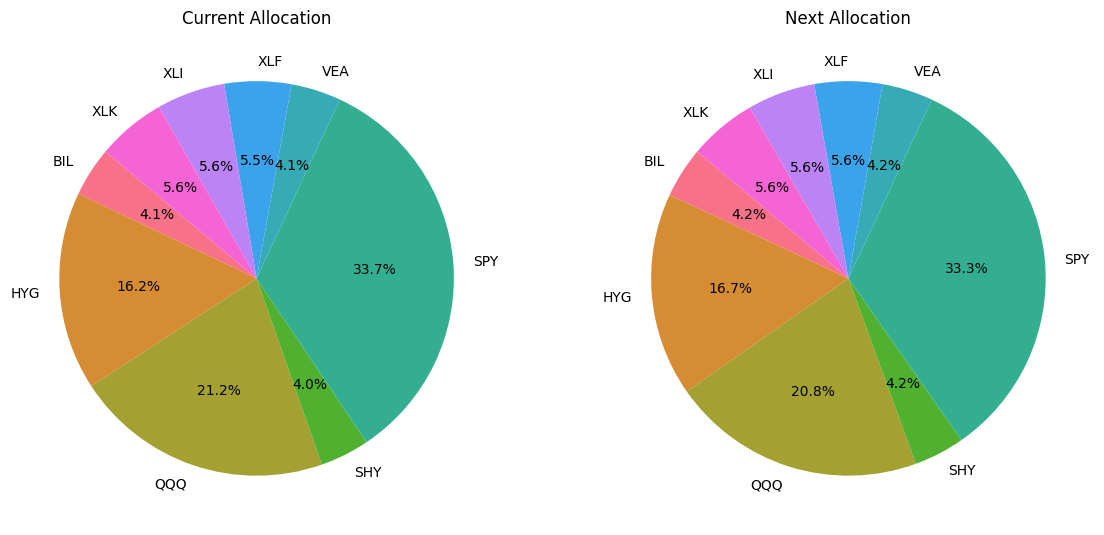

In [ ]:
plot_pie_chart(output_pie_weight)

####Historical Allocation - Asset Class Level

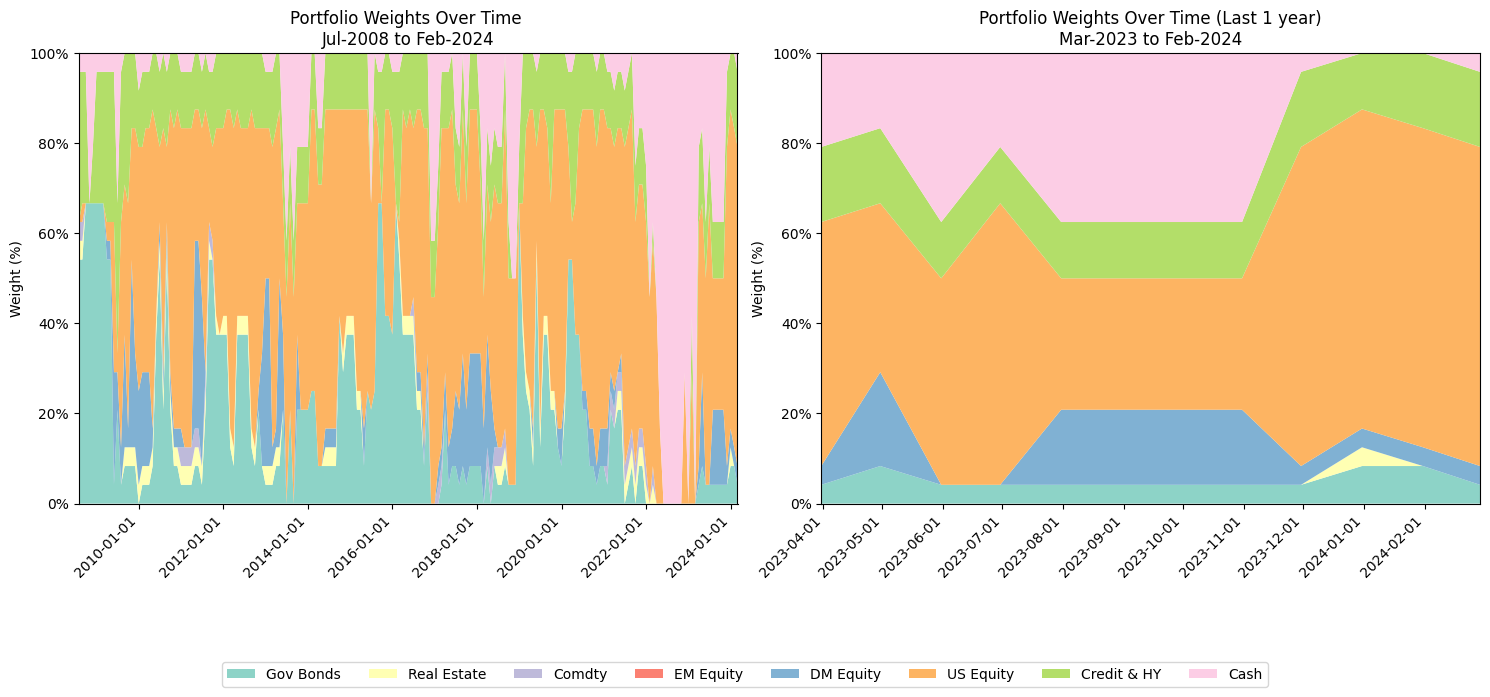

In [ ]:
combined_assets = combine_assets(overall_weight)
combined_assets = combined_assets.resample('M').last()
plot_weights_through_time(combined_assets)

## **Analytics**

## **Portfolio Stats & Charts**

####Portfolio Statastics

In [ ]:
portfolio_returns = performance_df_sum.rename('Portfolio')
benchmark_returns = benchmark_returns_weighted_sum.rename('Benchmark')
merged_returns_df = pd.merge(portfolio_returns, benchmark_returns, left_index=True, right_index=True, how='inner').iloc[1:]
print(calculate_financial_metrics(merged_returns_df))

                          Portfolio Benchmark
Metric                                       
Cumulative Return           317.49%   249.64%
CAGR                          9.64%     8.39%
Volatility                    8.53%    11.27%
Sharpe Ratio                   1.12      0.77
Sortino Ratio                  1.40      0.96
Max Drawdown                -13.99%   -25.19%
Longest Drawdown Duration       465       521
Skew                          -0.56     -0.03
Kurtosis                       4.31     12.04
1M Return                     2.73%     1.52%
3M Return                     7.70%     5.95%
1Y Return                     3.16%     1.72%
Best Day %                    2.90%     7.47%
Worst Day %                  -3.58%    -5.65%
Best Month %                  8.75%     7.72%
Worst Month %                -6.87%    -8.86%
Best Year %                  19.09%    21.72%
Worst Year %                 -3.64%   -13.61%


####Portfolio Plots

##### Initial Plotting Code

In [ ]:
# Initial Plotting Calcs
merged_returns_df_cumualtive = (1 + merged_returns_df).cumprod()
merged_returns_df_highwatermark = merged_returns_df_cumualtive.cummax()
merged_returns_df_drawdown = ((merged_returns_df_cumualtive - merged_returns_df_highwatermark) / merged_returns_df_highwatermark) * 100

##### Cumulative Return Plot

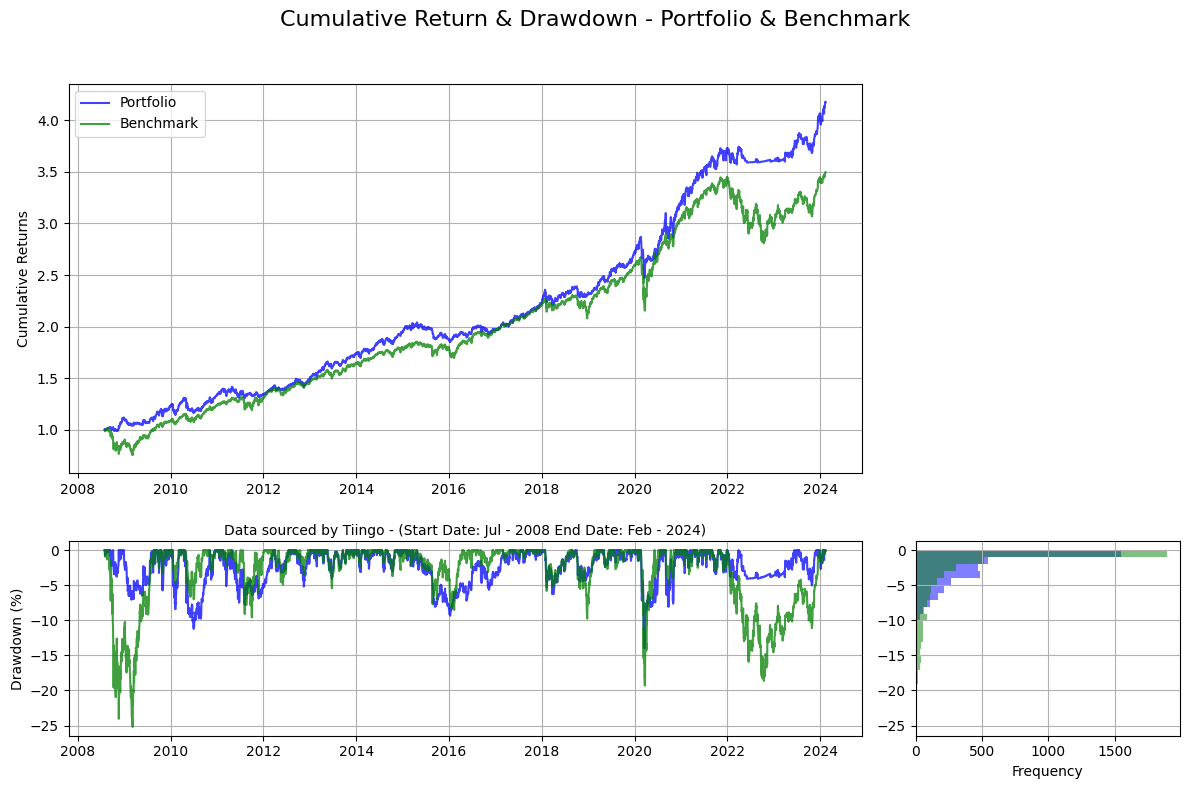

In [ ]:
# Plot Cumulative Returns & Drawdowns for both Portfolio & Benchmark.
create_cumula_rtn_drawdown_chart_function(merged_returns_df_cumualtive, merged_returns_df_drawdown)

#####Volatility Plot

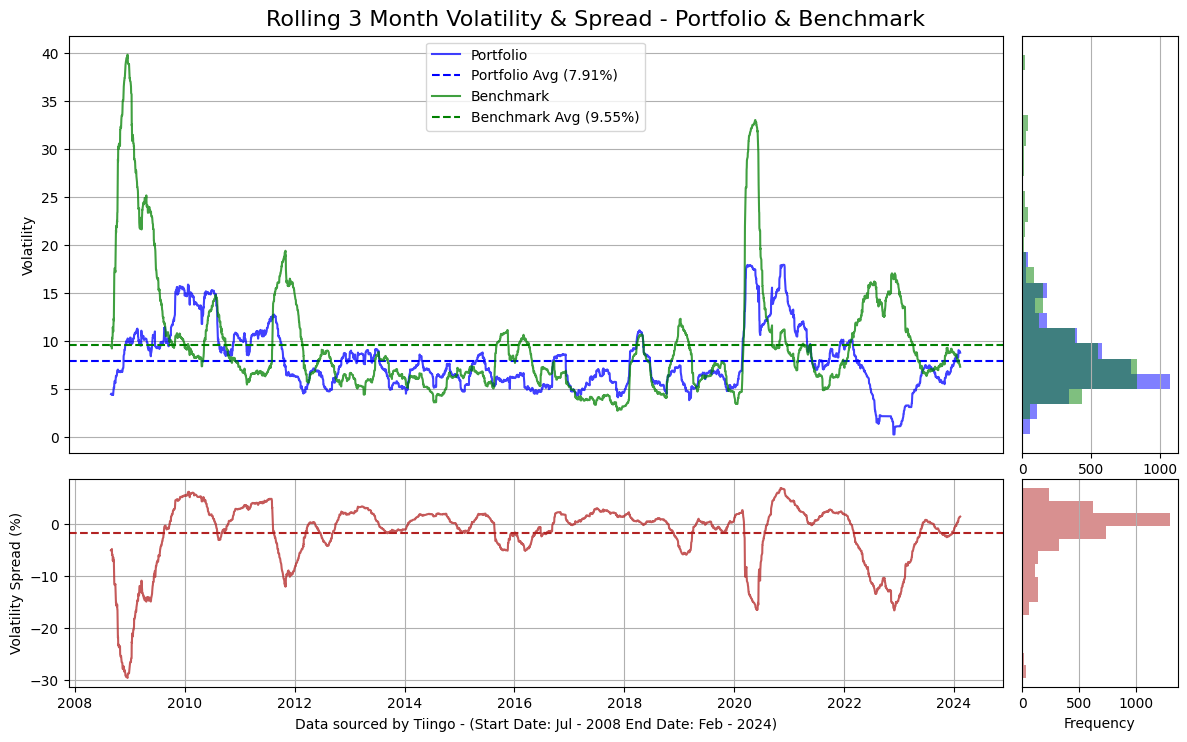

In [ ]:
# Plot Rolling Volatility for both Portfolio & Benchmark.
create_rolling_volatility_chart_function(merged_returns_df)

#####Monthly Returns

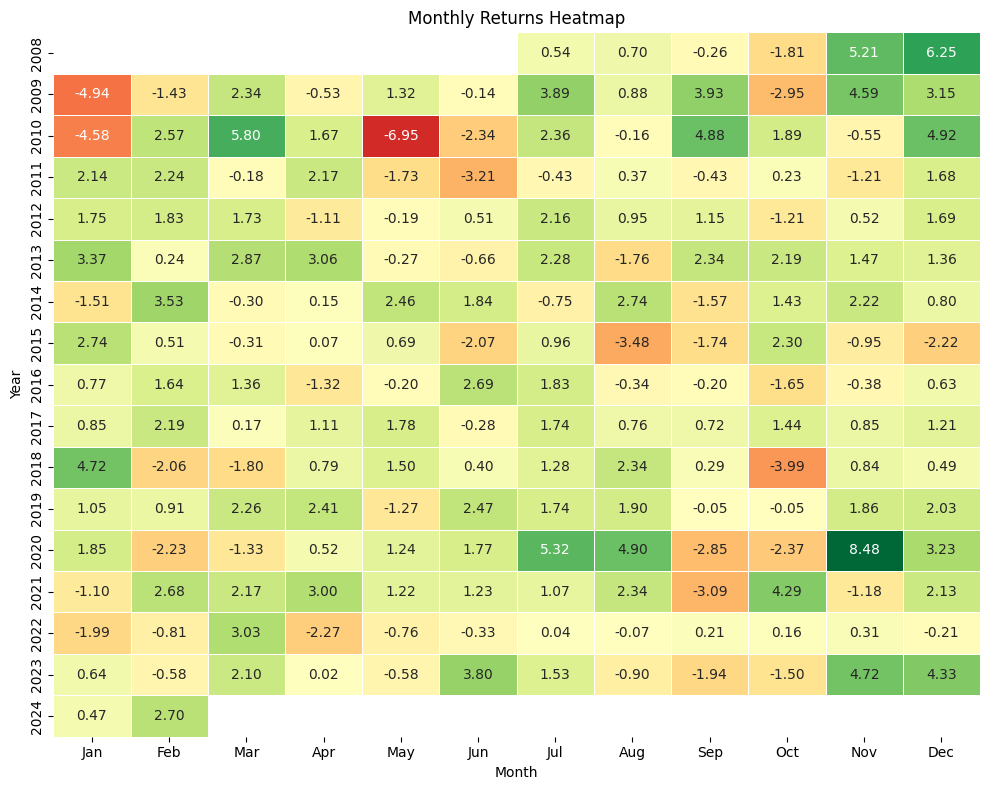

In [ ]:
plot_monthly_returns_heatmap(merged_returns_df['Portfolio'])

## **Execution**
Below the user can enter their account balance & the function will then run giving the user the number of shares they need to trade.


In [ ]:
# Enter Account Value
account_value = 10000

# Weights, Number of Shares & $ allocation.
exe_output = calculate_exposures_and_format(output_pie_weight, etf_last_price, account_value)
print(exe_output.to_string())

       Current Allocation  Next Allocation  Current Allocation $  Next Allocation $  Current Shares  Next Shares
BIL                  4.06             4.17                406.30             416.67             4.0          4.0
HYG                 16.24            16.67               1624.19            1666.67            21.0         21.0
QQQ                 21.17            20.83               2117.17            2083.33             4.0          4.0
SHY                  4.04             4.17                404.39             416.67             4.0          5.0
SPY                 33.66            33.33               3366.15            3333.33             6.0          6.0
VEA                  4.09             4.17                408.82             416.67             8.0          8.0
XLF                  5.48             5.56                547.73             555.56            13.0         14.0
XLI                  5.61             5.56                561.02             555.56             

In [ ]:
#TODO: Build a single report that exports to pdf or html.

In [ ]:
# # Mapping each ETF to its corresponding asset class as defined in combine_assets function
# etf_to_asset_class = {
#     'SHY': 'Gov Bonds', 'IEF': 'Gov Bonds', 'TLT': 'Gov Bonds', 'TIP': 'Gov Bonds',
#     'VNQ': 'Real Estate',
#     'DBC': 'Comdty', 'GLD': 'Comdty',
#     'EEM': 'EM Equity',
#     'VEA': 'DM Equity', 'EFA': 'DM Equity', 'VWO': 'DM Equity', 'VTI': 'DM Equity', 'EWJ': 'DM Equity',
#     'SPY': 'US Equity', 'QQQ': 'US Equity', 'IWM': 'US Equity',
#     'XLP': 'US Equity', 'XLE': 'US Equity', 'XLF': 'US Equity', 'XLV': 'US Equity',
#     'XLI': 'US Equity', 'XLK': 'US Equity', 'XLB': 'US Equity', 'XLU': 'US Equity', 'XLY': 'US Equity',
#     'HYG': 'Credit & HY', 'AGG': 'Credit & HY', 'LQD': 'Credit & HY',
#     'BIL': 'Cash'
# }

# # Maximum potential allocation for each ETF across all functions
# max_allocations_etf = {
#     'SHY': 25, 'IEF': 25, 'TLT': 25, 'TIP': 25, 'VNQ': 25, 'DBC': 10, 'GLD': 10,
#     'EEM': 25, 'VEA': 100, 'EFA': 100, 'VWO': 25, 'VTI': 25, 'EWJ': 25, 'SPY': 100,
#     'QQQ': 100, 'IWM': 25, 'XLP': 33, 'XLE': 33, 'XLF': 33, 'XLV': 33, 'XLI': 33,
#     'XLK': 33, 'XLB': 33, 'XLU': 33, 'XLY': 33, 'HYG': 25, 'AGG': 25, 'LQD': 25, 'BIL': 100
# }

# # Calculate maximum potential allocation for each asset class
# max_allocations_asset_class = {asset_class: 0 for asset_class in set(etf_to_asset_class.values())}

# for etf, max_allocation in max_allocations_etf.items():
#     asset_class = etf_to_asset_class[etf]
#     max_allocations_asset_class[asset_class] = max(max_allocations_asset_class[asset_class], max_allocation)

# max_allocations_asset_class

# from scipy.stats import zscore

# def normalize_data(data):
#     """
#     Normalize the data to have a minimum of 0 and a maximum of 1.
#     """
#     min_val = data.min()
#     max_val = data.max()
#     return (data - min_val) / (max_val - min_val)

# def combined_signal_strength(current_allocations, max_allocations):
#     """
#     Calculate a combined signal strength using allocation-to-maximum and z-score,
#     then normalize to ensure all values are between 0 and 1 and non-negative.

#     :param current_allocations: DataFrame with current allocations for each asset class.
#     :param max_allocations: Dictionary with maximum allocations for each asset class.
#     :return: DataFrame with normalized combined signal strength values.
#     """
#     # Calculate allocation-to-maximum
#     allocation_to_max = current_allocations.copy()
#     for asset_class in current_allocations.columns:
#         max_allocation = max_allocations.get(asset_class, 100)
#         allocation_to_max[asset_class] = (current_allocations[asset_class] / max_allocation) * 100

#     # Calculate z-scores for current allocations
#     z_scores = current_allocations.apply(zscore, axis=1)

#     # Combine allocation-to-maximum and z-scores
#     combined_strength = (allocation_to_max + z_scores) / 2

#     # Normalize to ensure values are between 0 and 1
#     normalized_strength = combined_strength.apply(normalize_data, axis=1)

#     return normalized_strength

# # Example usage
# normalized_strength_df = combined_signal_strength(combined_assets, max_allocations_asset_class)

# # print(normalized_strength_df.round(1).tail(100).to_string())
